In [1]:
import sys
sys.path.append("/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs")

In [2]:
import numpy as np
import random
import seaborn as sns
from typing import Optional
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, confusion_matrix
from sklearn.datasets import make_blobs, make_classification, make_moons, make_circles

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from imblearn.metrics import geometric_mean_score
from moms_losses import MMD_est_torch

In [3]:
# seed 고정
def set_random_seed(seed=1203):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [4]:
# 시각화 설정
sns.set_context('paper', font_scale=1.2)
sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})
plt.rcParams.update({
    'figure.figsize': (14, 30),
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.markersize': 6,
    'lines.linewidth': 0.8,
})

# seed 설정
seed = 1203

In [5]:
def generate_overlapping_classification(n_samples=1000, class_sep=0.5, random_state=1203):
    X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2,
                               n_redundant=0, n_clusters_per_class=2, weights=[0.5, 0.5],
                               flip_y=0, class_sep=class_sep, random_state=random_state)
    return X, y

def generate_blob_data(n_samples=1000, centers=3, cluster_std=1.0, random_state=1203):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std,
                      n_features=2, random_state=random_state)
    y = y % 2  # Convert to binary classification
    return X, y

def generate_gaussian_mixture(n_samples=1000, random_state=1203):
    np.random.seed(random_state)
    cov = [[1, 0], [0, 1]]
    mean1 = [-1, 1]
    mean2 = [1, -1]
    X1 = np.random.multivariate_normal(mean1, cov, n_samples // 10)
    X2 = np.random.multivariate_normal(mean2, cov, n_samples-n_samples // 10)
    X = np.vstack([X1, X2])
    y = np.array([0] * (n_samples // 10) + [1] * (n_samples-n_samples // 10))
    return X, y

In [6]:
def generate_imb_data(X, y, minor_y_cnt, seed=1203):
    """원본 데이터를 불균형하게 만드는 함수"""
    set_random_seed(seed)
    idx_minor = np.where(y == 0)[0]
    idx_major = np.where(y == 1)[0]
    if len(idx_minor) > minor_y_cnt:
        np.random.shuffle(idx_minor)
        idx_minor = idx_minor[:minor_y_cnt]
    idx_imb = np.concatenate((idx_minor, idx_major))
    X_imb = X[idx_imb]
    y_imb = y[idx_imb]
    return X_imb, y_imb

In [7]:
# 1. overlapping data
X_cls_bal, y_cls_bal = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                           n_redundant=0, n_clusters_per_class=2, 
                                           weights=[0.5, 0.5], flip_y=0.01, class_sep=0.6, random_state=seed)
X_cls_imb, y_cls_imb = generate_imb_data(X_cls_bal, y_cls_bal, minor_y_cnt=50, seed=seed)

# 2. half-moons 
X_moons_bal, y_moons_bal = make_moons(n_samples=1000, noise=0.25, random_state=seed)
X_moons_imb, y_moons_imb = generate_imb_data(X_moons_bal, y_moons_bal, minor_y_cnt=50, seed=seed)

# 3. circles 
X_circ_bal, y_circ_bal = make_circles(n_samples=1000, noise=0.15, factor=0.6, random_state=seed)
X_circ_imb, y_circ_imb = generate_imb_data(X_circ_bal, y_circ_bal, minor_y_cnt=50, seed=seed)

# 4. Blob 
X_blob_bal, y_blob_bal = generate_blob_data(n_samples=1000, centers=2, cluster_std=1.5, random_state=seed)
X_blob_imb, y_blob_imb = generate_imb_data(X_blob_bal, y_blob_bal, minor_y_cnt=50, seed=seed)

# 5. Gaussian Mixture 
X_gmm_bal, y_gmm_bal = generate_gaussian_mixture(n_samples=1000, random_state=seed)
X_gmm_imb, y_gmm_imb = generate_imb_data(X_gmm_bal, y_gmm_bal, minor_y_cnt=50, seed=seed)

In [8]:
datasets = [
    ("Sim1", X_cls_bal, y_cls_bal, X_cls_imb, y_cls_imb),
    ("Sim2", X_moons_bal, y_moons_bal, X_moons_imb, y_moons_imb),
    ("Sim3", X_circ_bal, y_circ_bal, X_circ_imb, y_circ_imb),
    ("Sim4", X_blob_bal, y_blob_bal, X_blob_imb, y_blob_imb),
    ("Sim5", X_gmm_bal, y_gmm_bal, X_gmm_imb, y_gmm_imb),
]

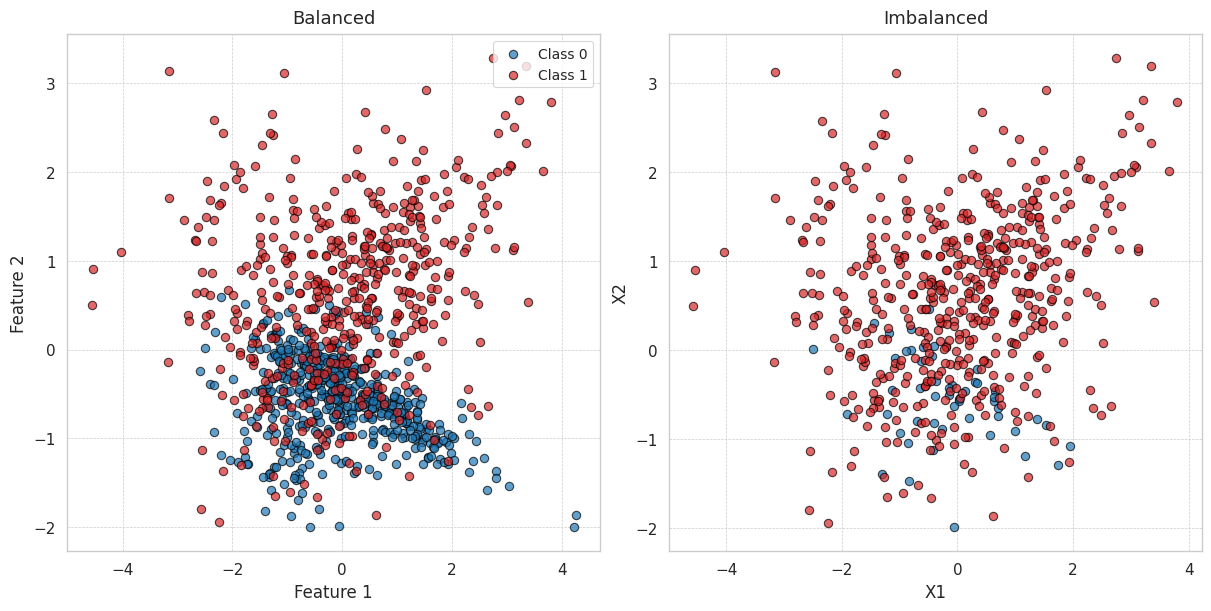

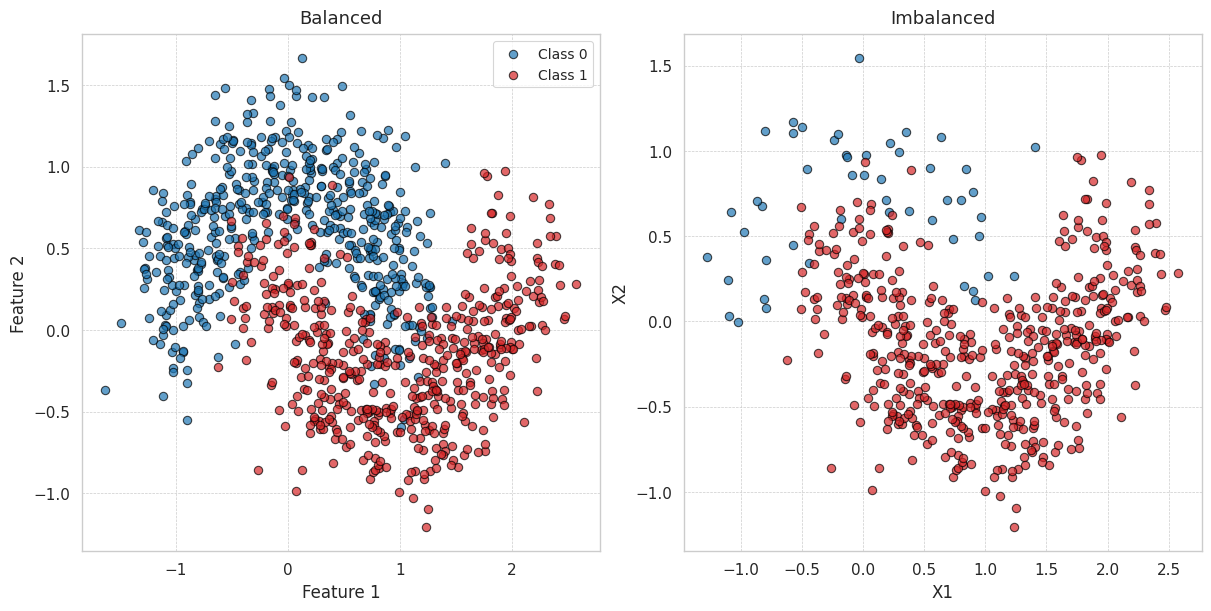

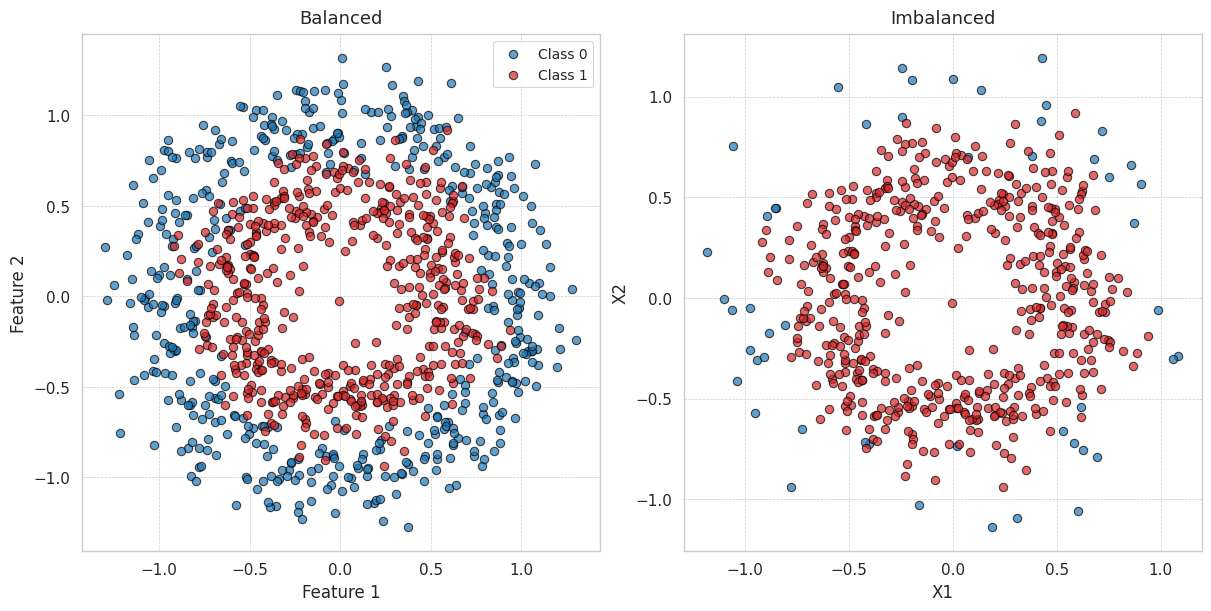

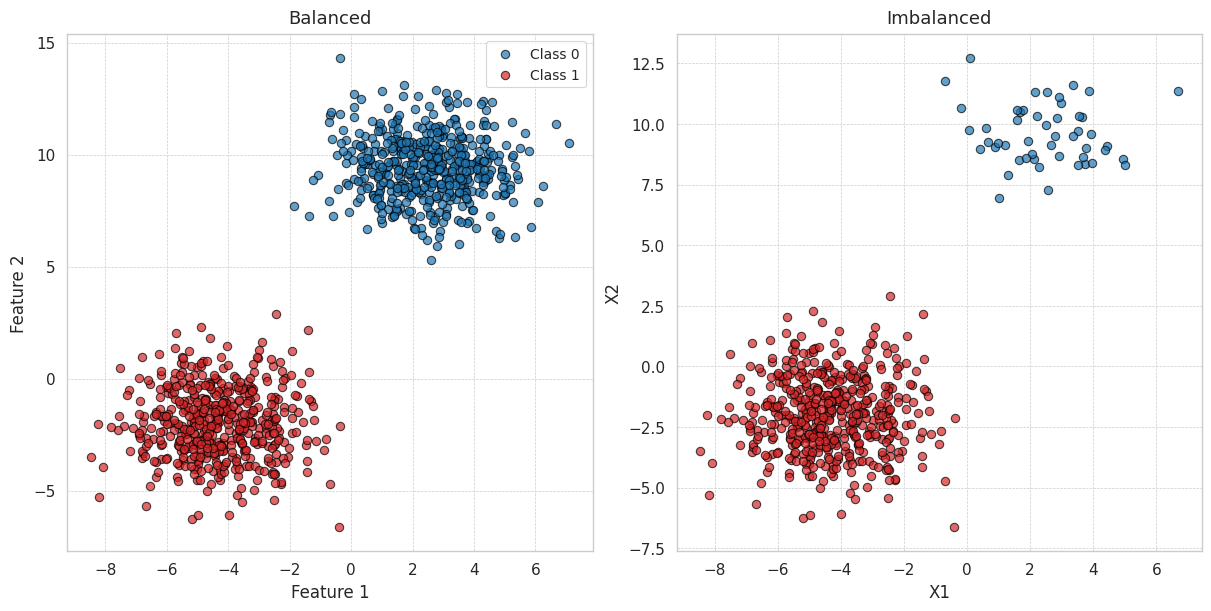

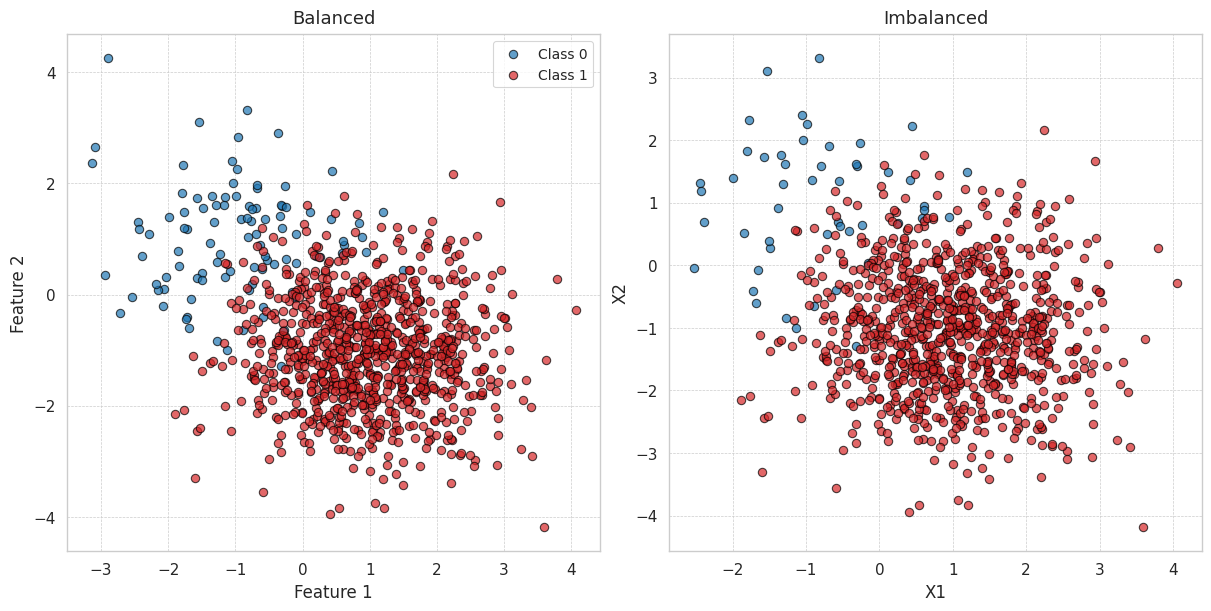

In [9]:
FIGSIZE = (12, 6)

for title, X_bal, y_bal, X_imb, y_imb in datasets:
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, constrained_layout=True)
    # ── Balanced subplot ──
    ax = axes[0]
    ax.scatter(
        X_bal[y_bal==0, 0], X_bal[y_bal==0, 1],
        c='tab:blue', alpha=0.7, edgecolor='k', label='Class 0'
    )
    ax.scatter(
        X_bal[y_bal==1, 0], X_bal[y_bal==1, 1],
        c='tab:red',  alpha=0.7, edgecolor='k', label='Class 1'
    )
    ax.set_title('Balanced', pad=8)
    ax.set_xlabel('Feature 1'); ax.set_ylabel('Feature 2')
    ax.legend(loc='upper right', frameon=True)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # ── Imbalanced subplot ──
    ax = axes[1]
    ax.scatter(
        X_imb[y_imb==0, 0], X_imb[y_imb==0, 1],
        c='tab:blue', alpha=0.7, edgecolor='k'
    )
    ax.scatter(
        X_imb[y_imb==1, 0], X_imb[y_imb==1, 1],
        c='tab:red',  alpha=0.7, edgecolor='k'
    )
    ax.set_title('Imbalanced', pad=8)
    ax.set_xlabel('X1'); ax.set_ylabel('X2')
    ax.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [11]:
def compute_danger_set(X_minor, X_major, seed, k=5):
    set_random_seed(seed)
    from sklearn.neighbors import NearestNeighbors
    X_minor_np = X_minor.detach().cpu().numpy()
    X_all = torch.cat([X_minor, X_major], dim=0)
    X_all_np = X_all.detach().cpu().numpy()
    
    nn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', n_jobs=-1)
    nn.fit(X_all_np)
    _, nn_idx = nn.kneighbors(X_minor_np)
    nn_idx = torch.tensor(nn_idx, device=X_minor.device)[:, 1:]

    maj_mask = nn_idx >= X_minor.shape[0]
    maj_cnt = maj_mask.sum(dim=1)

    danger_mask = maj_cnt > int(k * 0.5)
    all_maj_mask = maj_mask.all(dim=1)

    danger_set = X_minor[danger_mask & ~all_maj_mask]
    return danger_set

In [12]:
def compute_safe_maj(X_maj, X_min, q=0.75):
    min_dists = torch.cdist(X_maj, X_min).min(dim=1).values
    safe_thresh = torch.quantile(min_dists, q=q)
    safe_mask = min_dists > safe_thresh
    return X_maj[safe_mask]

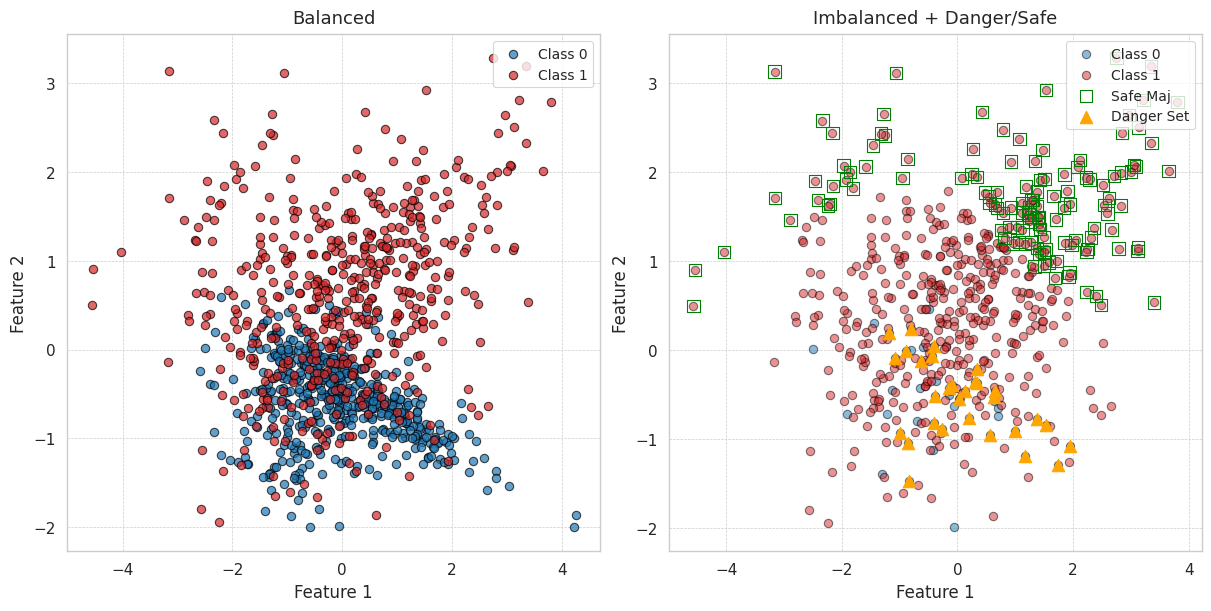

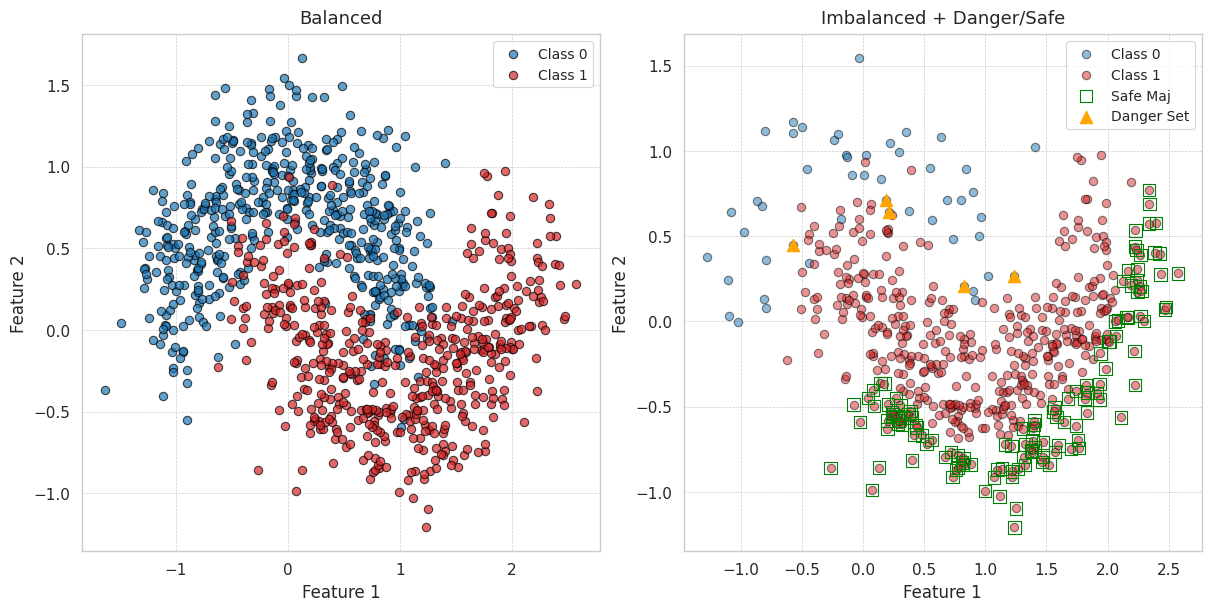

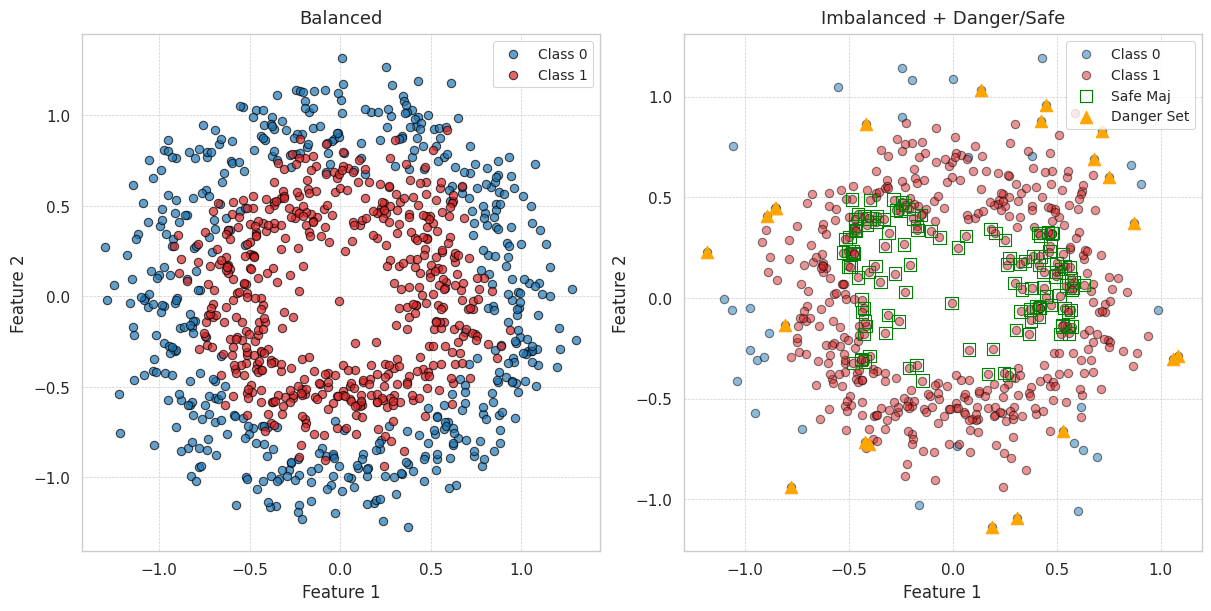

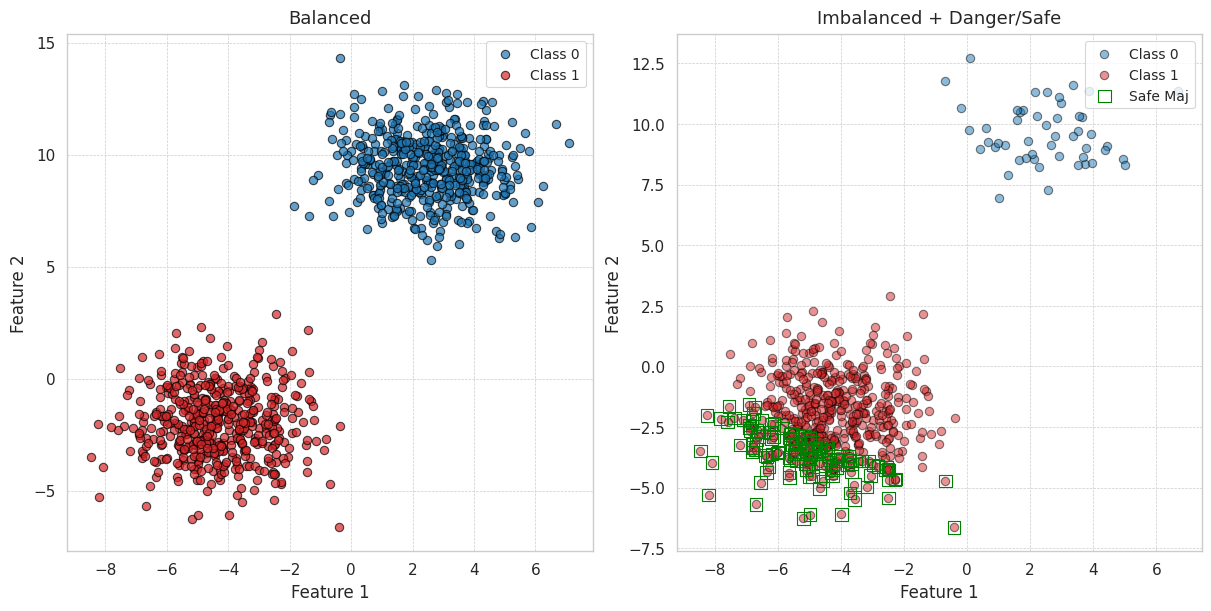

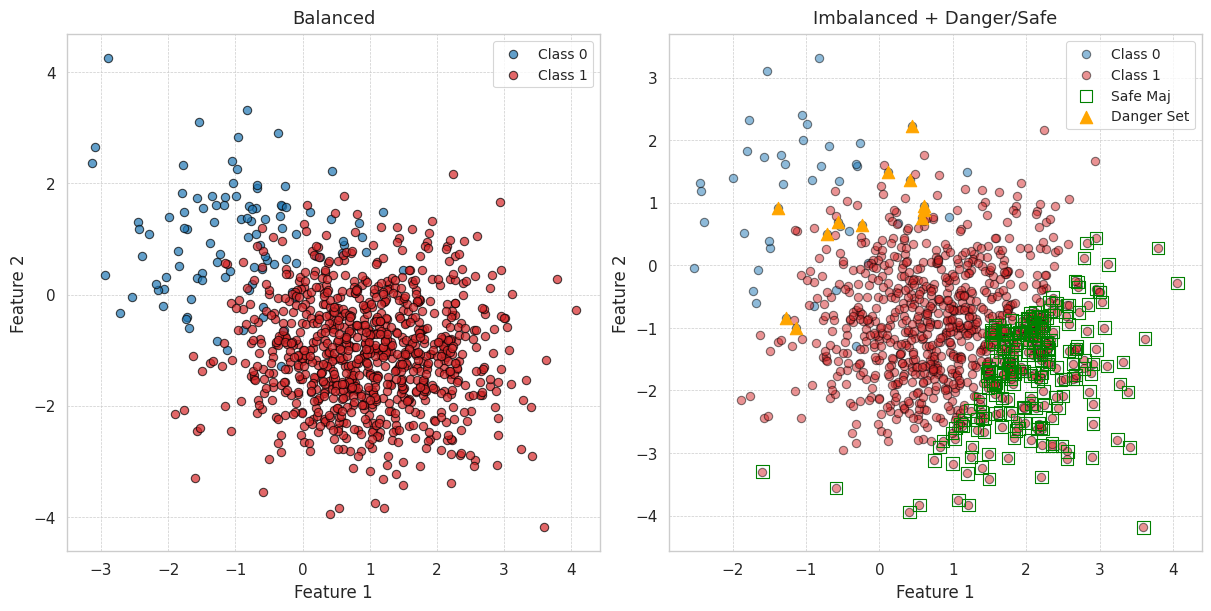

In [13]:
k = 5

for title, X_bal, y_bal, X_imb, y_imb in datasets:
    # Convert imbalanced arrays to torch for danger/safe computation
    X_min_t = torch.tensor(X_imb[y_imb==0], dtype=torch.float32)
    X_maj_t = torch.tensor(X_imb[y_imb==1], dtype=torch.float32)

    # Compute danger (minority) and safe (majority) sets
    danger_t = compute_danger_set(X_min_t, X_maj_t, seed, k=k)
    safe_t   = compute_safe_maj(X_maj_t, X_min_t, q=0.75)

    danger = danger_t.cpu().numpy()
    safe   = safe_t.cpu().numpy()

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, constrained_layout=True)

    # ── Balanced subplot ──
    ax = axes[0]
    ax.scatter(
        X_bal[y_bal==0, 0], X_bal[y_bal==0, 1],
        c='tab:blue', alpha=0.7, edgecolor='k', label='Class 0'
    )
    ax.scatter(
        X_bal[y_bal==1, 0], X_bal[y_bal==1, 1],
        c='tab:red', alpha=0.7, edgecolor='k', label='Class 1'
    )
    ax.set_title('Balanced', pad=8)
    ax.set_xlabel('Feature 1'); ax.set_ylabel('Feature 2')
    ax.legend(loc='upper right', frameon=True)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # ── Imbalanced subplot ──
    ax = axes[1]
    # Plot original classes
    ax.scatter(
        X_imb[y_imb==0, 0], X_imb[y_imb==0, 1],
        c='tab:blue', alpha=0.5, edgecolor='k', label='Class 0'
    )
    ax.scatter(
        X_imb[y_imb==1, 0], X_imb[y_imb==1, 1],
        c='tab:red', alpha=0.5, edgecolor='k', label='Class 1'
    )
    # Overlay safe majority
    if safe.size > 0:
        ax.scatter(
            safe[:, 0], safe[:, 1],
            facecolors='none', edgecolors='green',
            s=80, marker='s', label='Safe Maj'
        )
    # Overlay danger minority
    if danger.size > 0:
        ax.scatter(
            danger[:, 0], danger[:, 1],
            c='orange', marker='^', s=80,
            label='Danger Set'
        )
    ax.set_title('Imbalanced + Danger/Safe', pad=8)
    ax.set_xlabel('Feature 1'); ax.set_ylabel('Feature 2')
    ax.legend(loc='upper right', frameon=True)
    ax.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

In [14]:
def adaptive_kernel_width(
        X: torch.Tensor, 
        Y: torch.Tensor=None):
    # Convert numpy inputs to torch.Tensor
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    if Y is None:
        Y = X
    elif not isinstance(Y, torch.Tensor):
        Y = torch.tensor(Y, dtype=torch.float32)
    dists: torch.Tensor = torch.cdist(X, Y, p=2)
    bandwidth: torch.Tensor = torch.median(dists)
    return bandwidth 

In [15]:
def danger_aware_triplet_loss(
        X_trans: torch.Tensor,
        X_danger: torch.Tensor, 
        X_safe: torch.Tensor, 
        margin: float = 1.0
    ) -> torch.Tensor:
    """Compute a danger-aware triplet loss for transformed samples"""
    pos_dists = torch.cdist(X_trans, X_danger, p=2).min(dim=1).values
    neg_dists = torch.cdist(X_trans, X_safe, p=2).min(dim=1).values
    loss = torch.relu(pos_dists - neg_dists + margin).mean()    
    return loss

In [16]:
def train_autoencoder(
        autoencoder: nn.Module, 
        major_loader: torch.utils.data.DataLoader, 
        minor_loader: torch.utils.data.DataLoader, 
        device: torch.device,
        num_epochs: int = 2000, 
        lr: float = 1e-3, 
        beta: float = 0.0, 
        k: int = 5, 
        seed: Optional[int] = 1203,
        print_every: int = 500
    ) -> nn.Module:
    
    # 1) Setup
    set_random_seed(seed)
    autoencoder.to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-4)
    
    # 2) Training loop
    for epoch in range(1, num_epochs+1):
        autoencoder.train()
        epoch_mmd = 0.0
        epoch_trip = 0.0

        for (X_maj_batch, ), (X_min_batch, ) in zip(major_loader, minor_loader):
            X_maj = X_maj_batch.to(device)
            X_min = X_min_batch.to(device)
            
            X_trans = autoencoder(X_maj)
            
            # Compute MMD loss with adaptive bandwidth
            bw = adaptive_kernel_width(X_maj, X_min)
            mmd = MMD_est_torch(X_trans, X_min, kernel_type='gaussian', h=bw)
            
            if beta > 0.0:
                danger_set = compute_danger_set(X_min, X_maj, seed, k=k)
                safe_set = compute_safe_maj(X_maj, X_min, q=0.75)    
                
                if danger_set.numel() and safe_set.numel():
                    trip = danger_aware_triplet_loss(X_trans, danger_set, safe_set)
                else:
                    trip = torch.tensor(0.0, device=device)
            else:
                trip = torch.tensor(0.0, device=device)
                                    
            loss = mmd + beta * trip

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_mmd += mmd.item()
            epoch_trip += trip.item()

        # 3) Logging
        if epoch % print_every == 0 or epoch == num_epochs:
            n_iter = len(major_loader)
            print(
                f"Epoch [{epoch}/{num_epochs}] "
                f"MMD = {epoch_mmd/n_iter:.4f} "
                f"Trip = {epoch_trip/n_iter:.4f} (beta={beta})"
            )
    
    return autoencoder

In [17]:
def clf_exp_orig(sim_name, X_bal, y_bal, minor_y_cnt = 100, seed=1203):
    set_random_seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=seed)
    X_train_imb, y_train_imb = generate_imb_data(X_train, y_train, minor_y_cnt, seed=seed)
    X_test_imb, y_test_imb = generate_imb_data(X_test, y_test, minor_y_cnt, seed=seed)
    
    # 학습 시, 원본 imbalanced training set 그대로 사용
    clf = SVC(probability=True, random_state=seed)
    
    # minority: label 0, majority: label 1 -> 반전하여 minority가 positive (label 1)
    y_train_inv = 1 - y_train_imb
    y_test_inv = 1 - y_test_imb
    clf.fit(X_train_imb, y_train_inv)
    y_scores = clf.predict_proba(X_test_imb)[:,1]
    y_pred = clf.predict(X_test_imb)
    
    auroc = roc_auc_score(y_test_inv, y_scores)
    f1 = f1_score(y_test_inv, y_pred, pos_label=1)
    mAP = average_precision_score(y_test_inv, y_scores)
    gmean = geometric_mean_score(y_test_inv, y_pred)
    
    print(f"Metrics for {sim_name} (Original Imbalanced): AUROC={auroc:.4f}, G-mean={gmean:.4f}, mAP={mAP:.4f}, F1={f1:.4f}")
    return {"AUROC": auroc, "Gmean": gmean, "mAP": mAP, "F1": f1}

In [18]:
def clf_vis_exp(sim_name, X_bal, y_bal, beta, minor_y_cnt=100, seed=1203):
    set_random_seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=seed)
    X_train_imb, y_train_imb = generate_imb_data(X_train, y_train, minor_y_cnt, seed=seed)
    X_test_imb, y_test_imb = generate_imb_data(X_test, y_test, minor_y_cnt, seed=seed)

    idx_min = np.where(y_train_imb == 0)[0]
    idx_maj = np.where(y_train_imb == 1)[0]
    X_min_train = X_train_imb[idx_min]
    X_maj_train = X_train_imb[idx_maj]

    n_min, n_maj = len(idx_min), len(idx_maj)
    n_gen = n_maj - n_min

    if n_gen > 0:
        rand_indices = np.random.choice(n_maj, size=n_gen, replace=False)
        X_maj_sample = X_maj_train[rand_indices]

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        autoencoder = Autoencoder(input_dim=X_train.shape[1], latent_dim=32)

        X_min_tensor = torch.tensor(X_min_train, dtype=torch.float32)
        X_maj_sample_tensor = torch.tensor(X_maj_sample, dtype=torch.float32)
        minor_dataset = TensorDataset(X_min_tensor)
        major_dataset = TensorDataset(X_maj_sample_tensor)
        minor_loader = DataLoader(minor_dataset, batch_size=len(minor_dataset), shuffle=True)
        major_loader = DataLoader(major_dataset, batch_size=len(major_dataset), shuffle=True)

        trained_autoencoder = train_autoencoder(autoencoder, major_loader, minor_loader,
                                                device, num_epochs=1000, lr=1e-3*(1+100*beta), beta=beta, k=5)

        trained_autoencoder.eval()
        with torch.no_grad():
            X_syn = trained_autoencoder(X_maj_sample_tensor.to(device)).cpu().numpy()
    else:
        X_syn = np.empty((0, X_train.shape[1]))

    X_new = np.concatenate([X_min_train, X_syn, X_maj_train], axis=0)
    y_new = np.concatenate([np.zeros(len(X_min_train)), np.zeros(len(X_syn)), np.ones(len(X_maj_train))], axis=0)

    y_new_inv = 1 - y_new

    clf = SVC(probability=True, random_state=seed)
    clf.fit(X_new, y_new_inv)
    y_scores = clf.predict_proba(X_test_imb)[:, 1]
    y_pred = clf.predict(X_test_imb)

    auroc = roc_auc_score(1 - y_test_imb, y_scores)
    f1 = f1_score(1 - y_test_imb, y_pred, pos_label=1)
    mAP = average_precision_score(1 - y_test_imb, y_scores)
    gmean = geometric_mean_score(1 - y_test_imb, y_pred)


    FIGSIZE = (12, 6)
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, constrained_layout=True)

    ax = axes[0]
    ax.scatter(
        X_maj_train[:, 0], X_maj_train[:, 1],
        c='tab:red', alpha=0.7, edgecolor='k', label='Majority Class'
    )
    ax.scatter(
        X_min_train[:, 0], X_min_train[:, 1],
        c='tab:blue', alpha=0.7, edgecolor='k', label='Minority Class'
    )
    if n_gen > 0:
        ax.scatter(
            X_syn[:, 0], X_syn[:, 1],
            c='limegreen', marker='s', s=30, alpha=0.7, edgecolor='k', label='Synthetic Minority'
        )
    ax.set_title(f'After Oversampling (beta={beta})', pad=8)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='upper right', frameon=True)
    ax.grid(True, linestyle='--', linewidth=0.5)

    ax = axes[1]
    ax.scatter(
        X_train_imb[y_train_imb==1, 0], X_train_imb[y_train_imb==1, 1],
        c='tab:red', alpha=0.7, edgecolor='k'
    )
    ax.scatter(
        X_train_imb[y_train_imb==0, 0], X_train_imb[y_train_imb==0, 1],
        c='tab:blue', alpha=0.7, edgecolor='k'
    )
    ax.set_title('Original Imbalanced Data', pad=8)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

    print(f"Metrics for {sim_name} (beta: {beta}): AUROC={auroc:.4f}, G-mean={gmean:.4f}, mAP={mAP:.4f}, F1={f1:.4f}")
    return {"AUROC": auroc, "Gmean": gmean, "mAP": mAP, "F1": f1}

In [19]:
def run_clf_exp(seed):
    set_random_seed(seed)
    beta_list = [0.0, 0.005, 0.01, 0.05, 0.1]
    results = {}

    sim_generators = {
        "Sim1": lambda: generate_overlapping_classification(n_samples=1000, class_sep=0.5, random_state=seed),
        "Sim2": lambda: make_moons(n_samples=1000, noise=0.25, random_state=seed),
        "Sim3": lambda: make_circles(n_samples=1000, noise=0.15, factor=0.6, random_state=seed),
        "Sim4": lambda: generate_blob_data(n_samples=1000, centers=3, cluster_std=1.0, random_state=seed),
        "Sim5": lambda: generate_gaussian_mixture(n_samples=1000, random_state=seed),
    }

    sim_names = list(sim_generators.keys())

    for sim_name in sim_names:
        X_bal, y_bal = sim_generators[sim_name]()
        results.setdefault(sim_name, {})["Original"] = clf_exp_orig(sim_name, X_bal, y_bal)
        results[sim_name]["Oversampled"] = {}
        for beta in beta_list:
            print(f"\n===== {sim_name} | beta={beta} =====")
            metrics = clf_vis_exp(sim_name, X_bal, y_bal, beta)
            results[sim_name]["Oversampled"][beta] = metrics
    
    for sim_name in results:
        print(f"\nResults for {sim_name}:")
        print("  Original Imbalanced:")
        for metric, value in results[sim_name]["Original"].items():
            print(f"    {metric}: {value:.4f}")
        print("  Oversampled:")
        for beta in results[sim_name]["Oversampled"]:
            m = results[sim_name]["Oversampled"][beta]
            print(f"    beta={beta}: AUROC={m['AUROC']:.4f}, G-mean={m['Gmean']:.4f}, mAP={m['mAP']:.4f}, F1={m['F1']:.4f}")
    return results

Metrics for Sim1 (Original Imbalanced): AUROC=0.8077, G-mean=0.3412, mAP=0.7797, F1=0.2087

===== Sim1 | beta=0.0 =====
Epoch [500/1000] MMD = 0.0007 Trip = 0.0000 (beta=0.0)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.0)


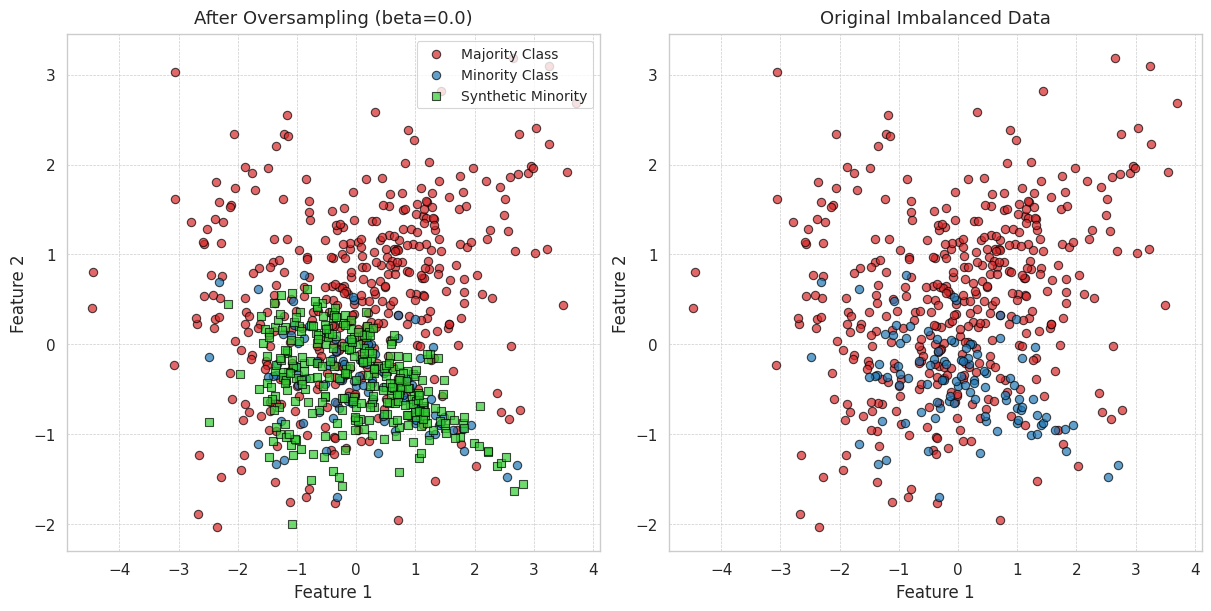

Metrics for Sim1 (beta: 0.0): AUROC=0.8975, G-mean=0.8062, mAP=0.8347, F1=0.8435

===== Sim1 | beta=0.005 =====
Epoch [500/1000] MMD = 0.0006 Trip = 0.0223 (beta=0.005)
Epoch [1000/1000] MMD = 0.0001 Trip = 0.0245 (beta=0.005)


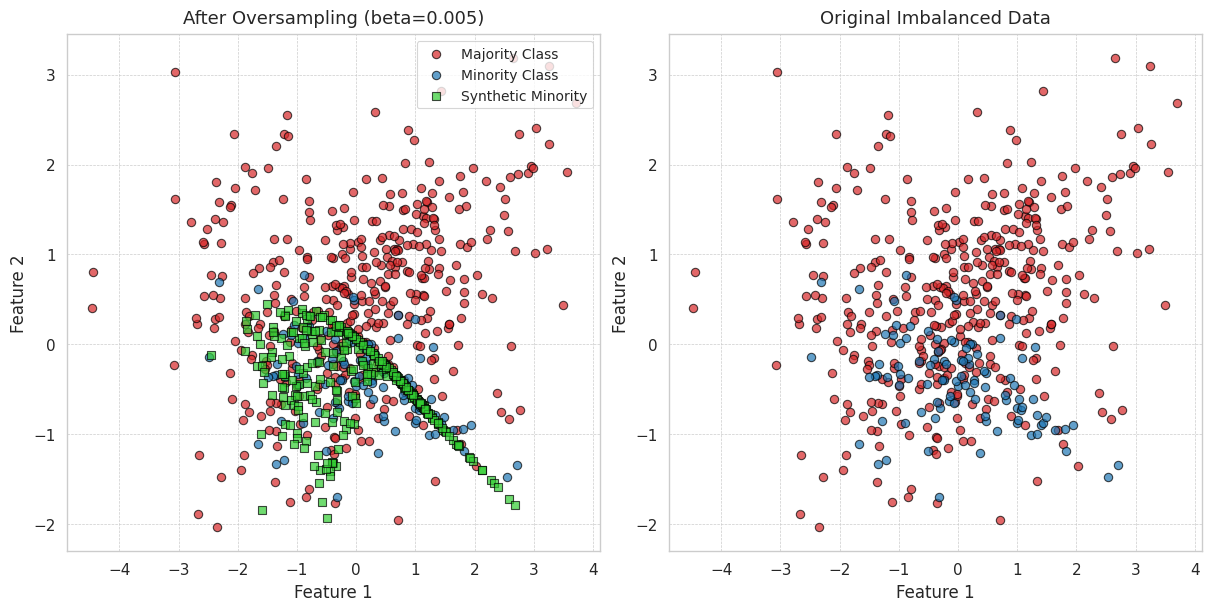

Metrics for Sim1 (beta: 0.005): AUROC=0.8967, G-mean=0.8139, mAP=0.8532, F1=0.8458

===== Sim1 | beta=0.01 =====
Epoch [500/1000] MMD = 0.0006 Trip = 0.0174 (beta=0.01)
Epoch [1000/1000] MMD = 0.0001 Trip = 0.0150 (beta=0.01)


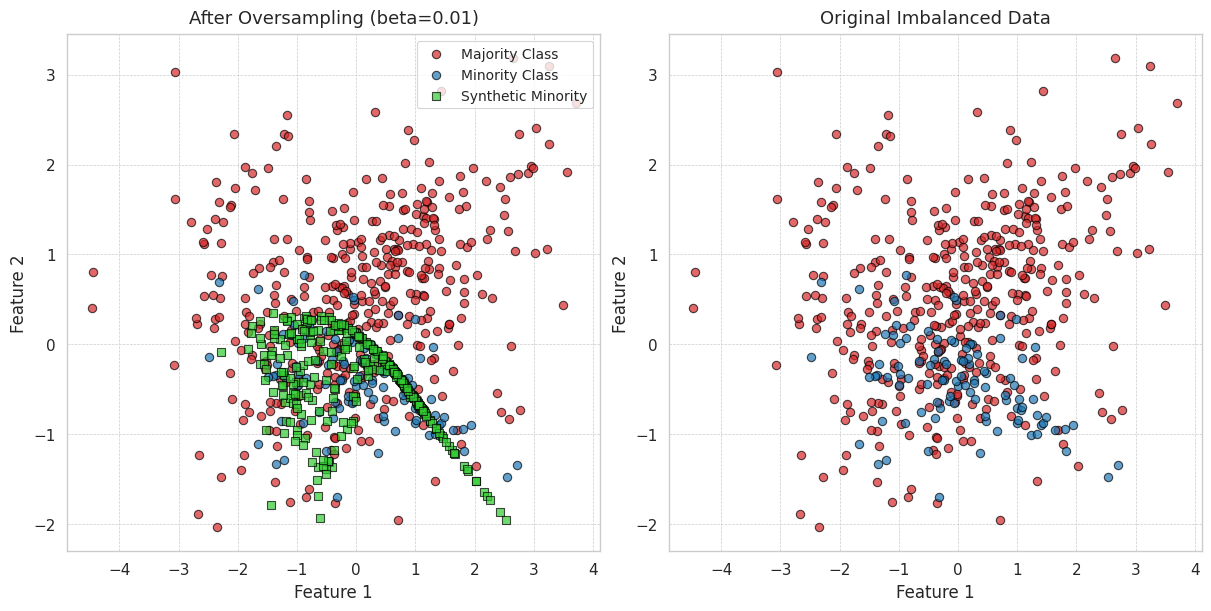

Metrics for Sim1 (beta: 0.01): AUROC=0.8931, G-mean=0.8096, mAP=0.8413, F1=0.8407

===== Sim1 | beta=0.05 =====
Epoch [500/1000] MMD = 0.0006 Trip = 0.0000 (beta=0.05)
Epoch [1000/1000] MMD = 0.0005 Trip = 0.0001 (beta=0.05)


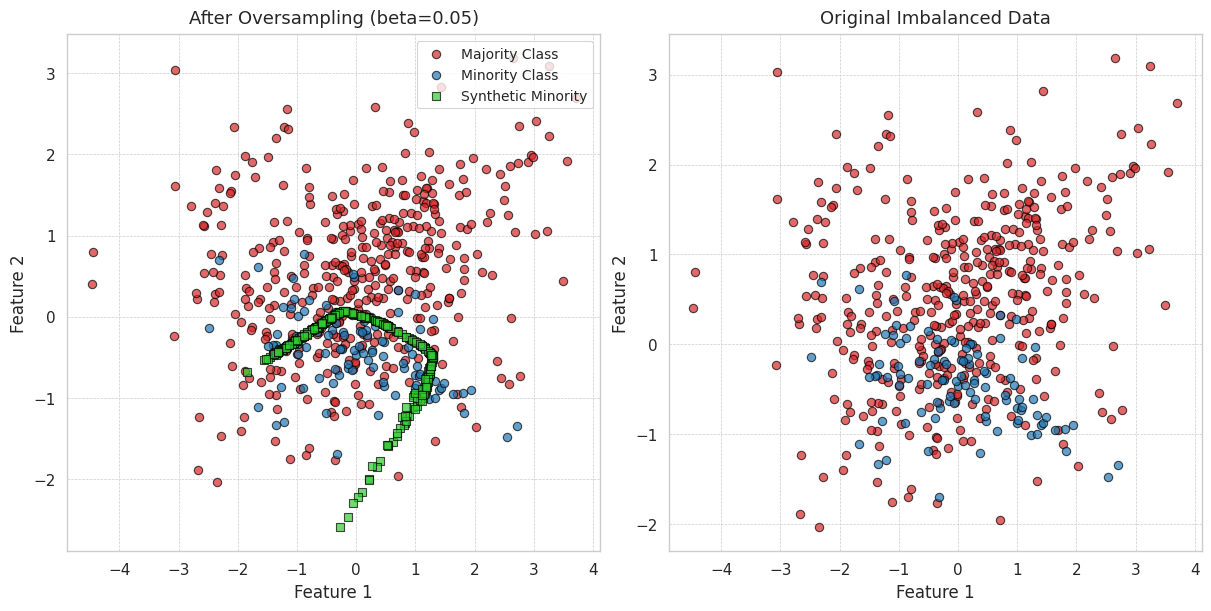

Metrics for Sim1 (beta: 0.05): AUROC=0.8627, G-mean=0.7576, mAP=0.8064, F1=0.7736

===== Sim1 | beta=0.1 =====
Epoch [500/1000] MMD = 0.0008 Trip = 0.0000 (beta=0.1)
Epoch [1000/1000] MMD = 0.0008 Trip = 0.0000 (beta=0.1)


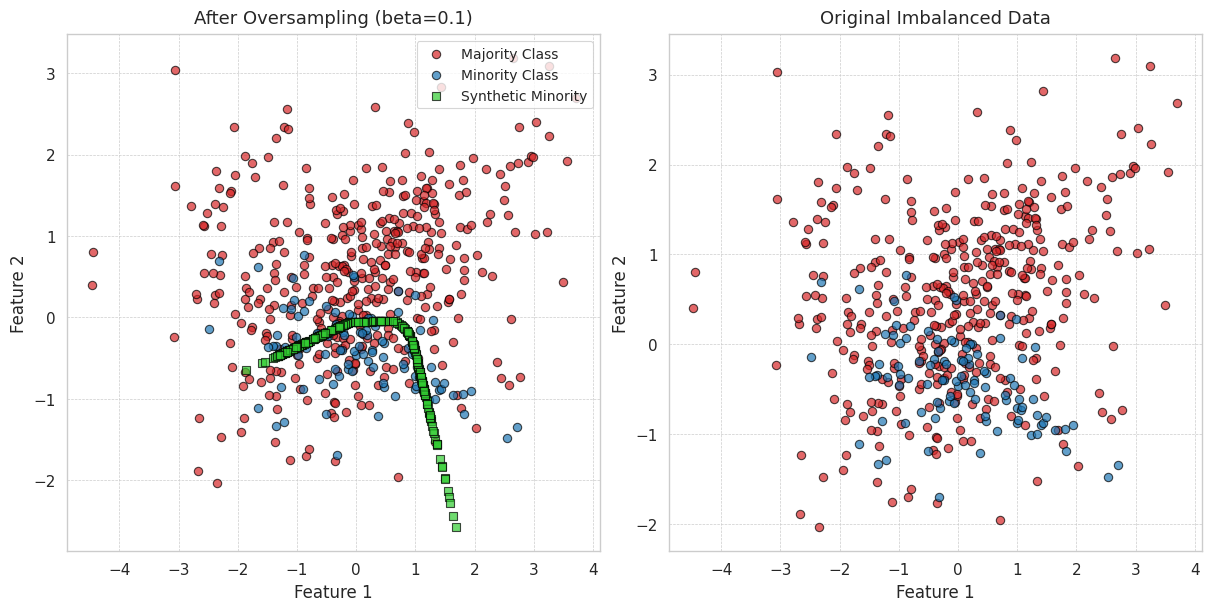

Metrics for Sim1 (beta: 0.1): AUROC=0.8727, G-mean=0.7831, mAP=0.8374, F1=0.7962
Metrics for Sim2 (Original Imbalanced): AUROC=0.9816, G-mean=0.9033, mAP=0.9824, F1=0.8995

===== Sim2 | beta=0.0 =====
Epoch [500/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.0)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.0)


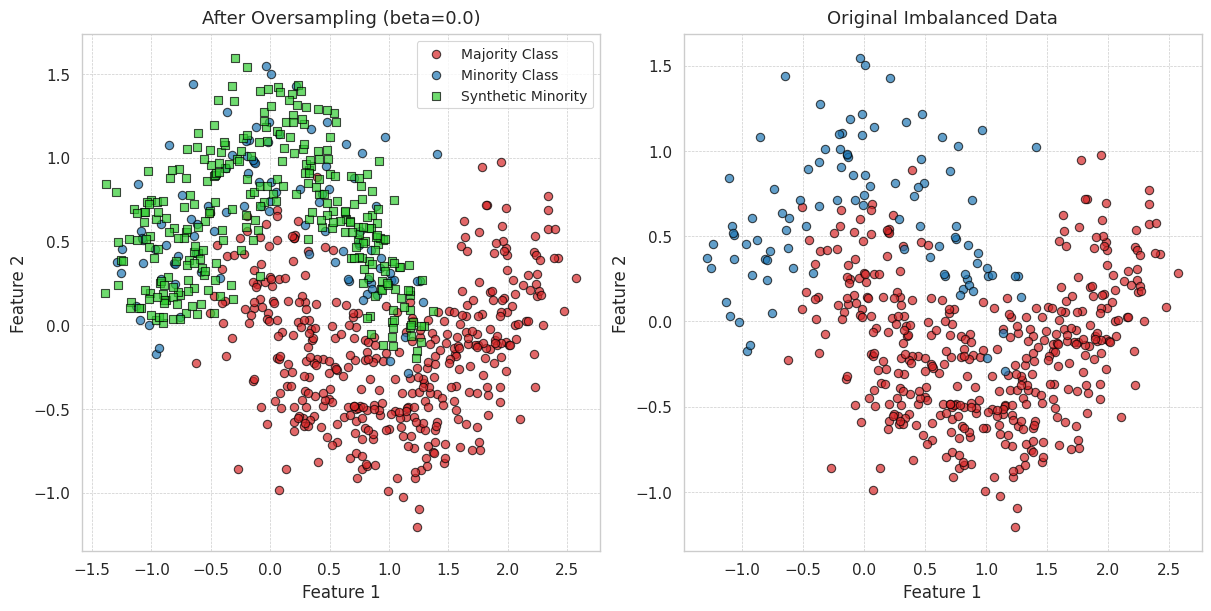

Metrics for Sim2 (beta: 0.0): AUROC=0.9808, G-mean=0.9398, mAP=0.9815, F1=0.9412

===== Sim2 | beta=0.005 =====
Epoch [500/1000] MMD = 0.0000 Trip = 0.3865 (beta=0.005)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.3787 (beta=0.005)


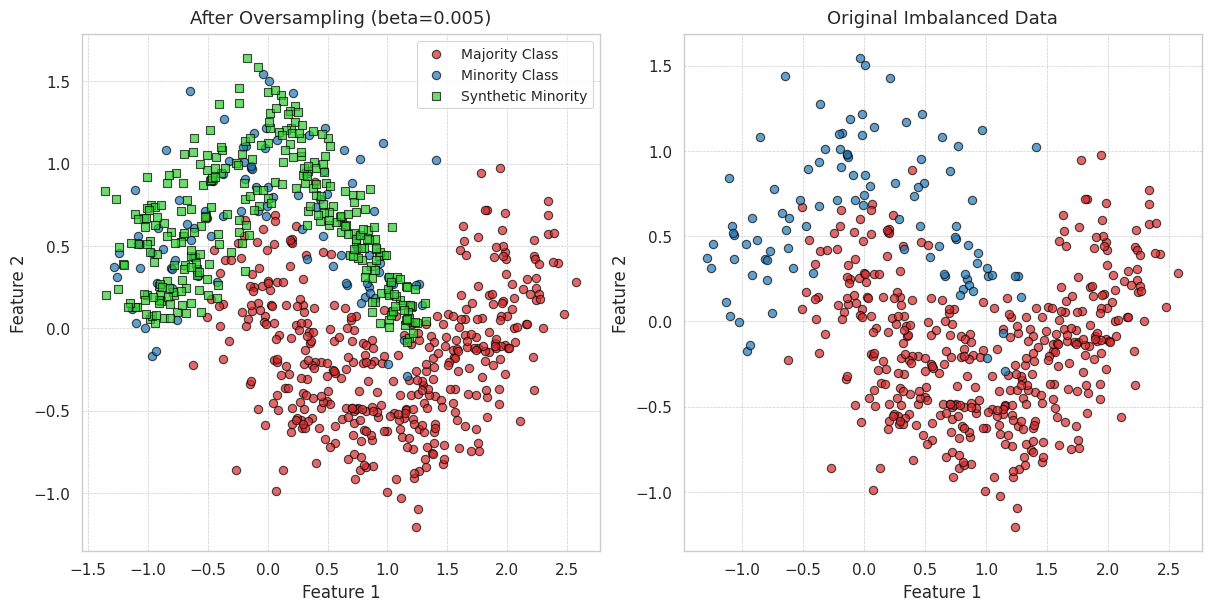

Metrics for Sim2 (beta: 0.005): AUROC=0.9786, G-mean=0.9247, mAP=0.9795, F1=0.9268

===== Sim2 | beta=0.01 =====
Epoch [500/1000] MMD = 0.0001 Trip = 0.3767 (beta=0.01)
Epoch [1000/1000] MMD = 0.0001 Trip = 0.3615 (beta=0.01)


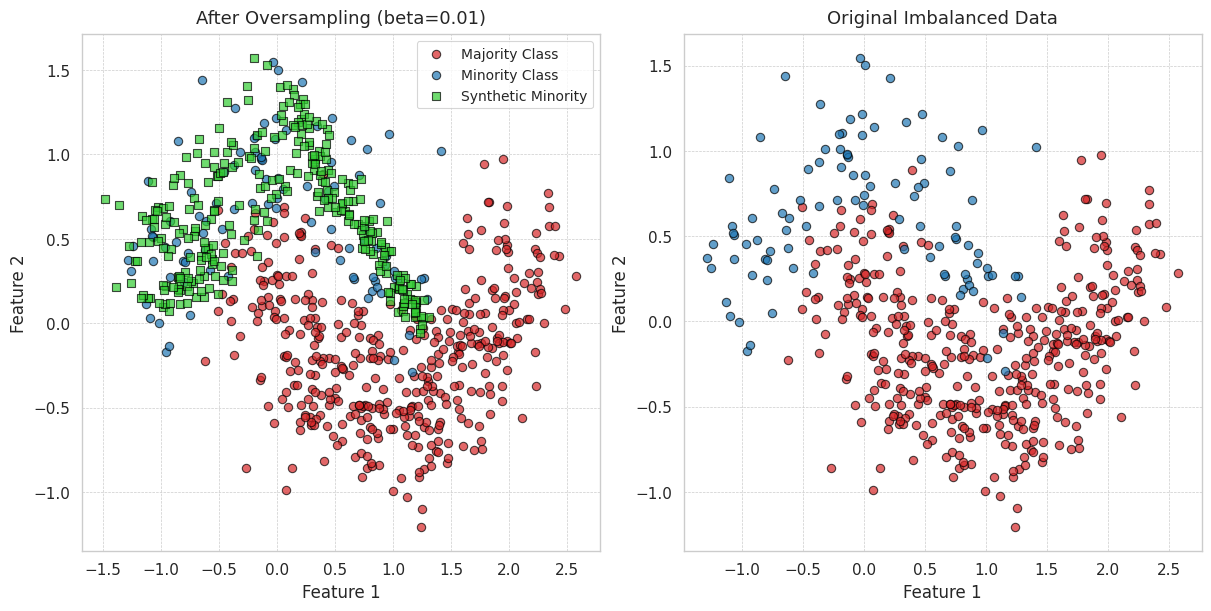

Metrics for Sim2 (beta: 0.01): AUROC=0.9783, G-mean=0.9247, mAP=0.9794, F1=0.9268

===== Sim2 | beta=0.05 =====
Epoch [500/1000] MMD = 0.0036 Trip = 0.2796 (beta=0.05)
Epoch [1000/1000] MMD = 0.0033 Trip = 0.2743 (beta=0.05)


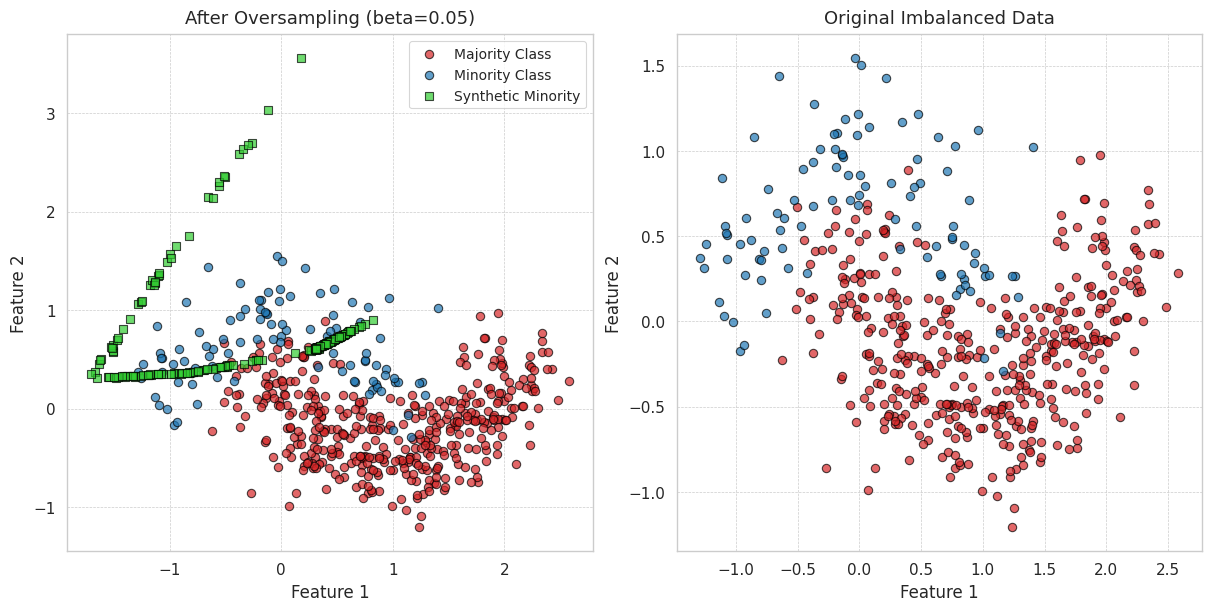

Metrics for Sim2 (beta: 0.05): AUROC=0.9744, G-mean=0.9149, mAP=0.9749, F1=0.9137

===== Sim2 | beta=0.1 =====
Epoch [500/1000] MMD = 0.0067 Trip = 0.2405 (beta=0.1)
Epoch [1000/1000] MMD = 0.0065 Trip = 0.2375 (beta=0.1)


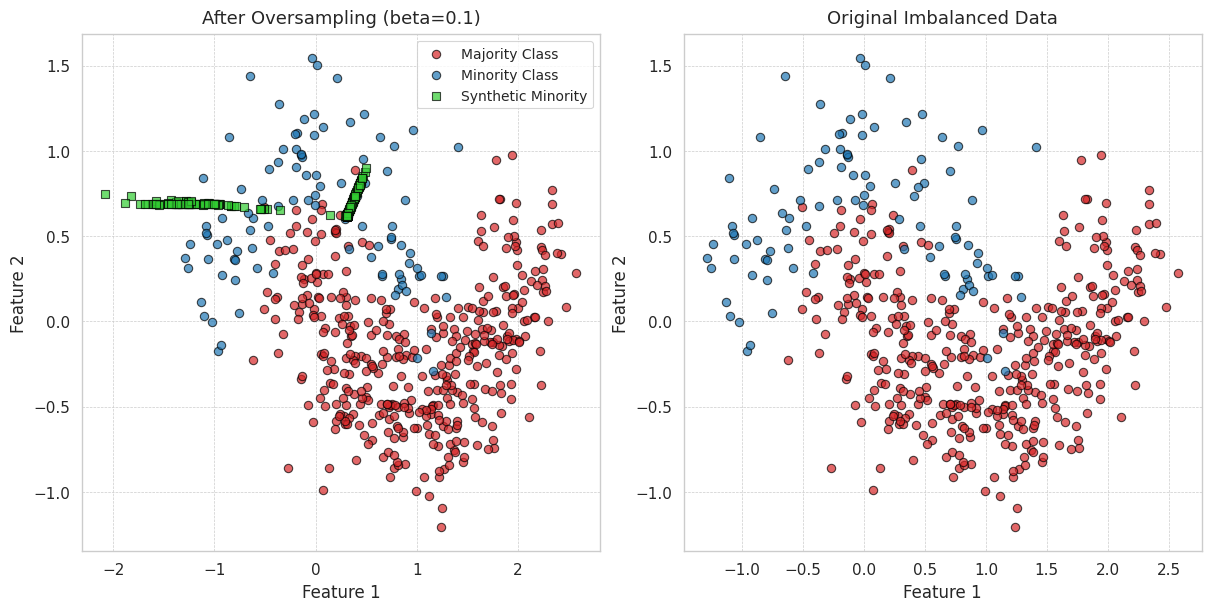

Metrics for Sim2 (beta: 0.1): AUROC=0.9778, G-mean=0.9295, mAP=0.9781, F1=0.9278
Metrics for Sim3 (Original Imbalanced): AUROC=0.9716, G-mean=0.8787, mAP=0.9752, F1=0.8715

===== Sim3 | beta=0.0 =====
Epoch [500/1000] MMD = 0.0004 Trip = 0.0000 (beta=0.0)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.0)


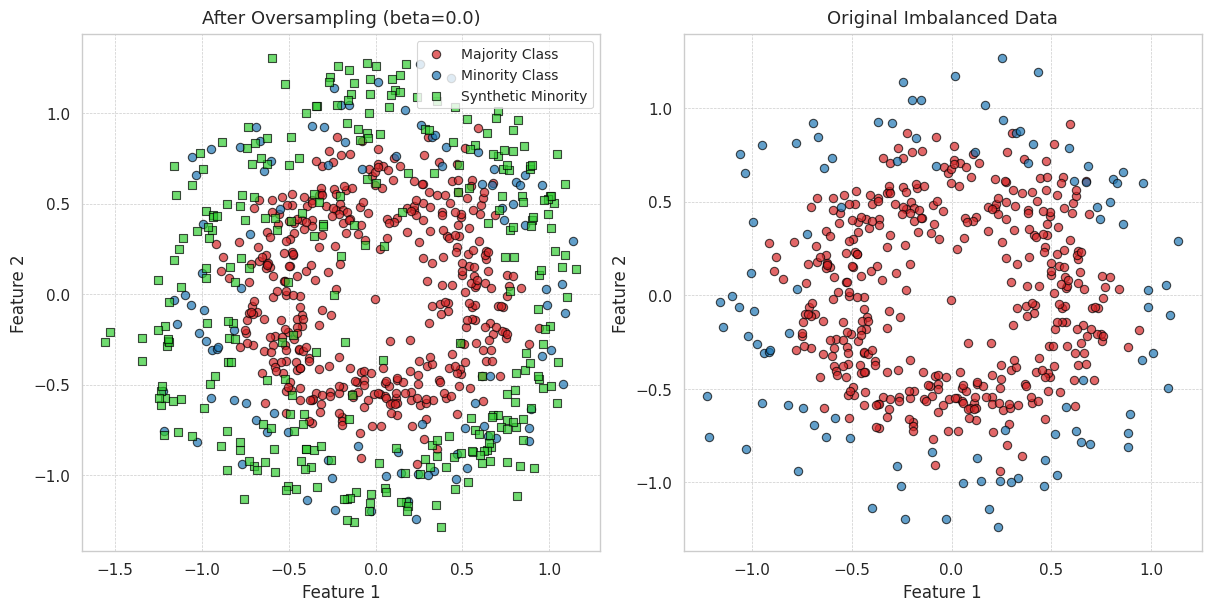

Metrics for Sim3 (beta: 0.0): AUROC=0.9762, G-mean=0.9198, mAP=0.9780, F1=0.9184

===== Sim3 | beta=0.005 =====
Epoch [500/1000] MMD = 0.0000 Trip = 0.8328 (beta=0.005)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.7997 (beta=0.005)


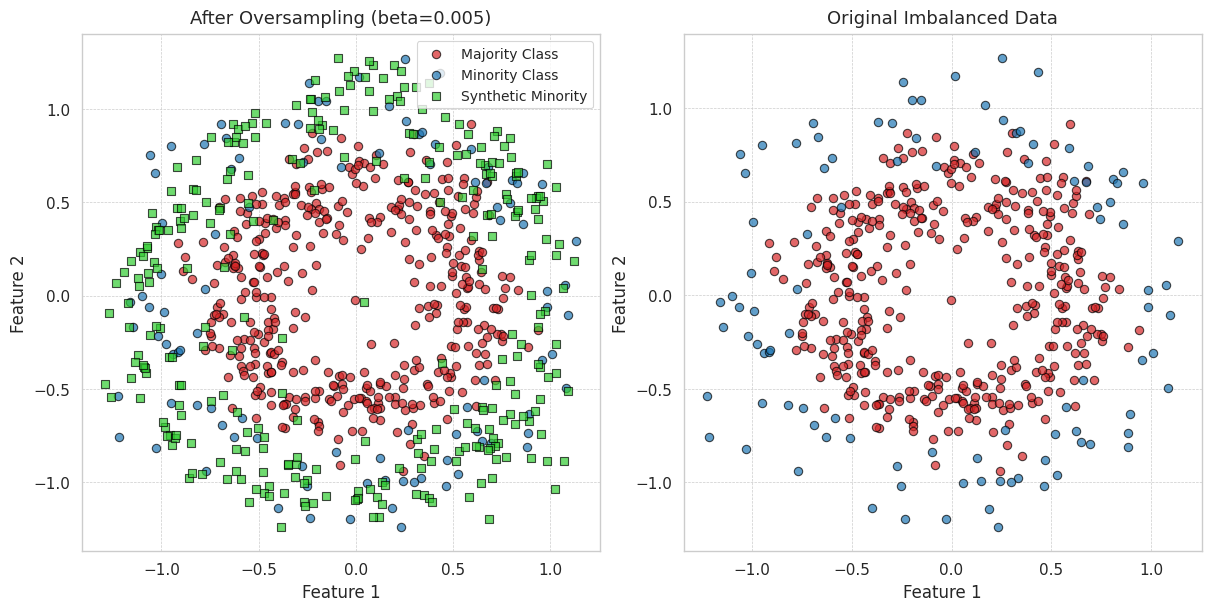

Metrics for Sim3 (beta: 0.005): AUROC=0.9748, G-mean=0.8949, mAP=0.9771, F1=0.8934

===== Sim3 | beta=0.01 =====
Epoch [500/1000] MMD = 0.0001 Trip = 0.8141 (beta=0.01)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.7782 (beta=0.01)


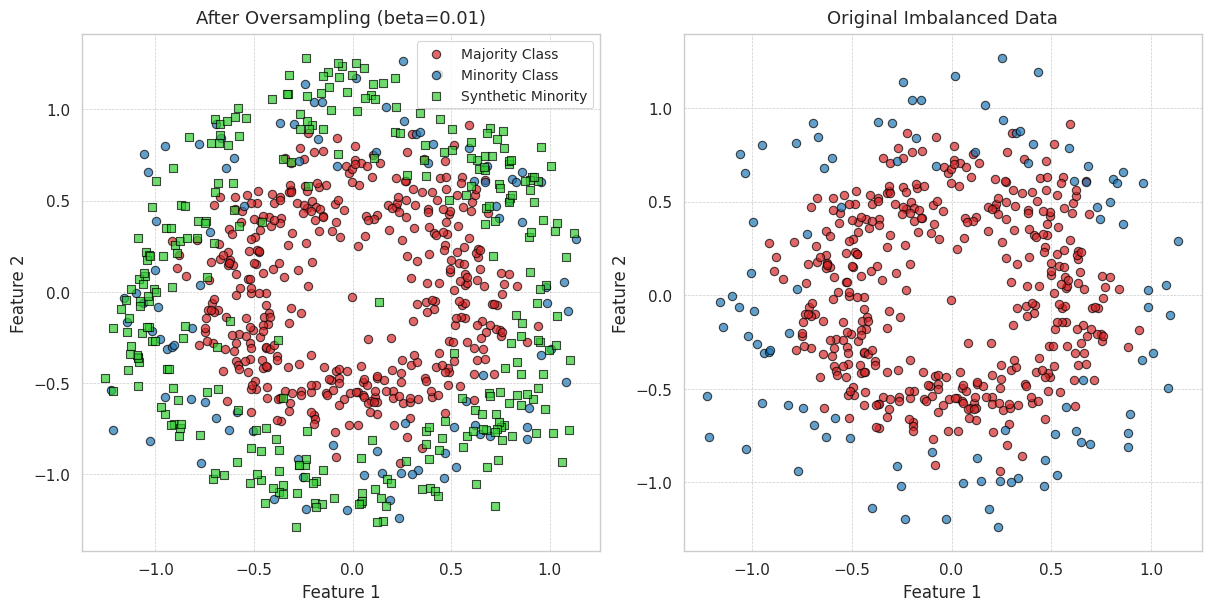

Metrics for Sim3 (beta: 0.01): AUROC=0.9756, G-mean=0.9050, mAP=0.9773, F1=0.9045

===== Sim3 | beta=0.05 =====
Epoch [500/1000] MMD = 0.0003 Trip = 0.6909 (beta=0.05)
Epoch [1000/1000] MMD = 0.0005 Trip = 0.6498 (beta=0.05)


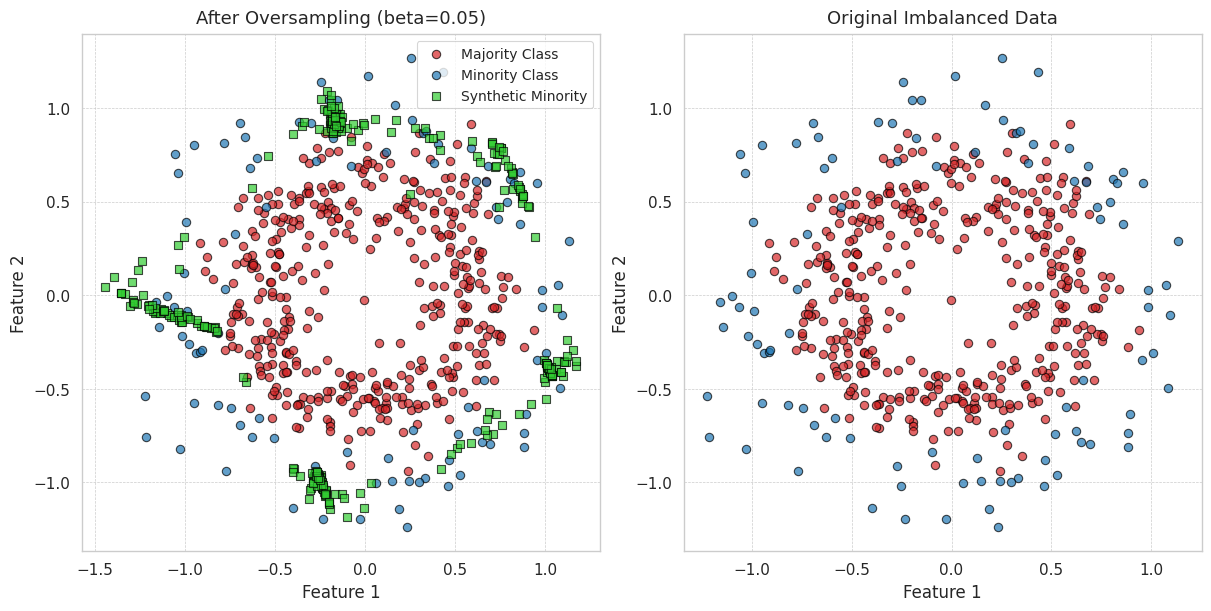

Metrics for Sim3 (beta: 0.05): AUROC=0.9760, G-mean=0.9039, mAP=0.9793, F1=0.9005

===== Sim3 | beta=0.1 =====
Epoch [500/1000] MMD = 0.0007 Trip = 0.7073 (beta=0.1)
Epoch [1000/1000] MMD = 0.0006 Trip = 0.6797 (beta=0.1)


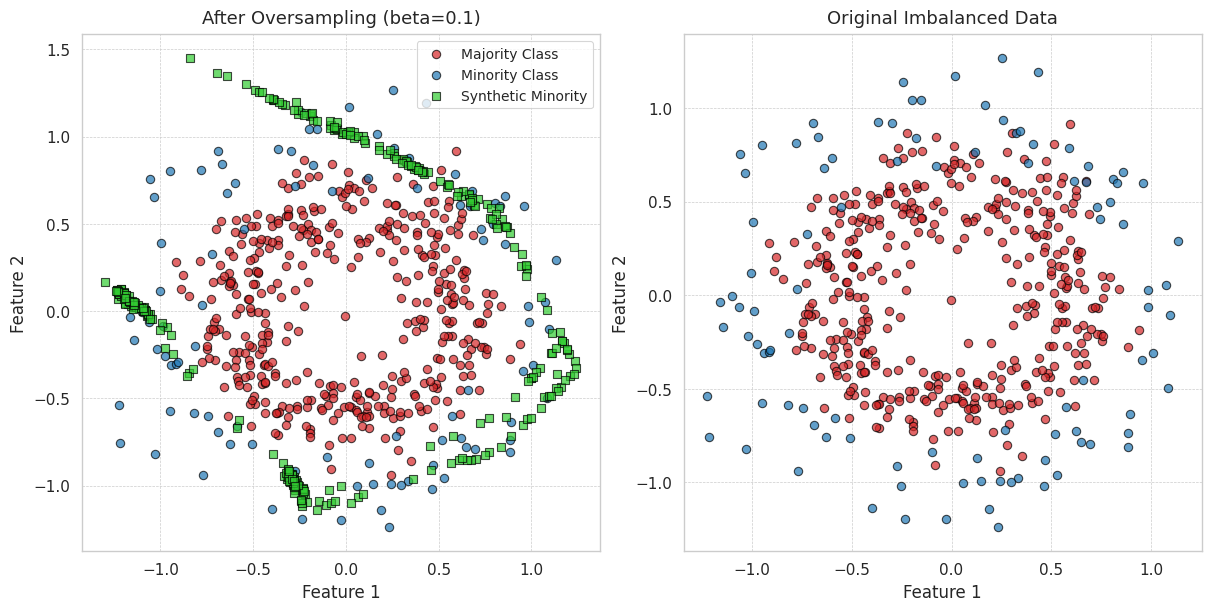

Metrics for Sim3 (beta: 0.1): AUROC=0.9704, G-mean=0.8886, mAP=0.9739, F1=0.8842
Metrics for Sim4 (Original Imbalanced): AUROC=0.8222, G-mean=0.6782, mAP=0.9011, F1=0.6301

===== Sim4 | beta=0.0 =====
Epoch [500/1000] MMD = 0.0008 Trip = 0.0000 (beta=0.0)
Epoch [1000/1000] MMD = 0.0005 Trip = 0.0000 (beta=0.0)


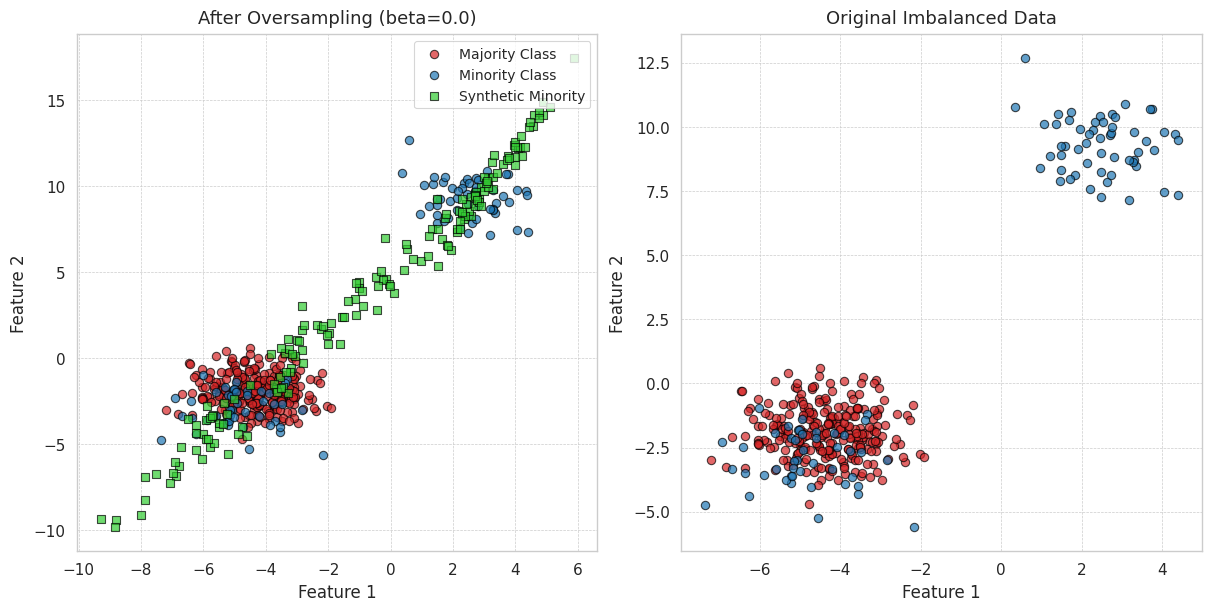

Metrics for Sim4 (beta: 0.0): AUROC=0.7958, G-mean=0.6824, mAP=0.8900, F1=0.6400

===== Sim4 | beta=0.005 =====
Epoch [500/1000] MMD = 0.0008 Trip = 1.8270 (beta=0.005)
Epoch [1000/1000] MMD = 0.0005 Trip = 1.6310 (beta=0.005)


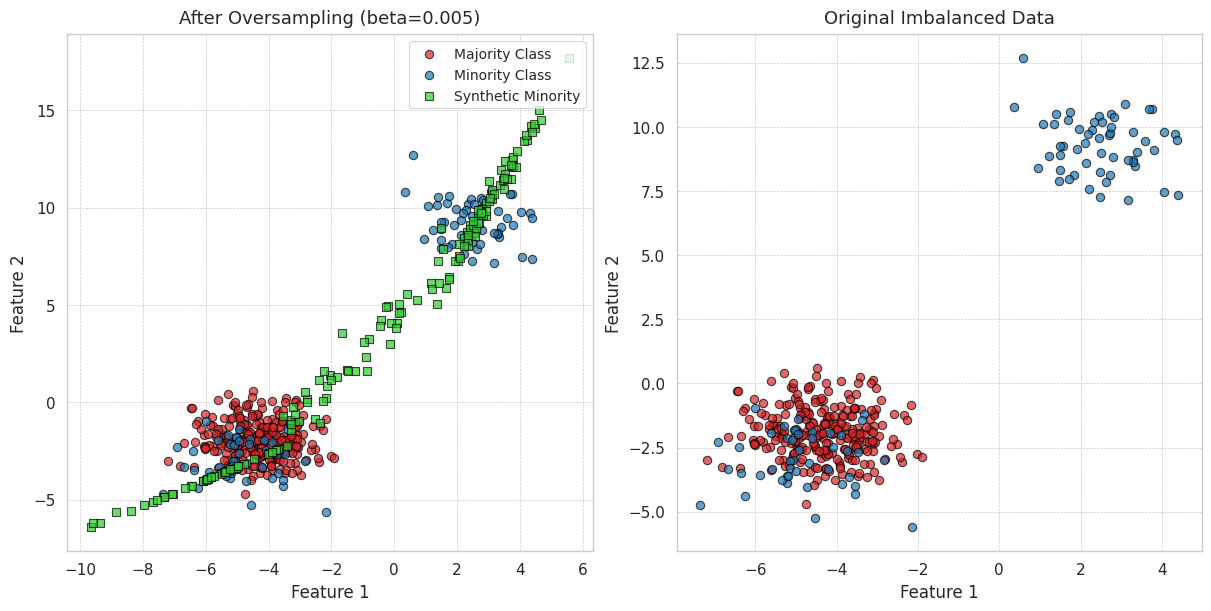

Metrics for Sim4 (beta: 0.005): AUROC=0.7961, G-mean=0.6895, mAP=0.8901, F1=0.6490

===== Sim4 | beta=0.01 =====
Epoch [500/1000] MMD = 0.0008 Trip = 1.7611 (beta=0.01)
Epoch [1000/1000] MMD = 0.0007 Trip = 1.7356 (beta=0.01)


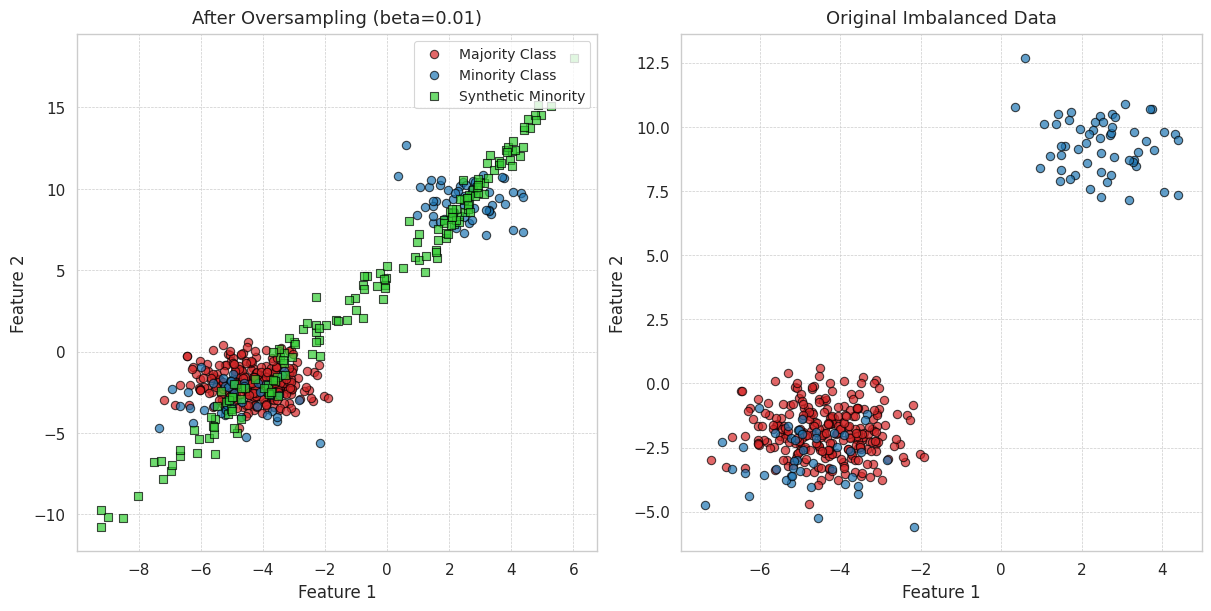

Metrics for Sim4 (beta: 0.01): AUROC=0.7866, G-mean=0.6804, mAP=0.8868, F1=0.6351

===== Sim4 | beta=0.05 =====
Epoch [500/1000] MMD = 0.0024 Trip = 1.4320 (beta=0.05)
Epoch [1000/1000] MMD = 0.0097 Trip = 1.0548 (beta=0.05)


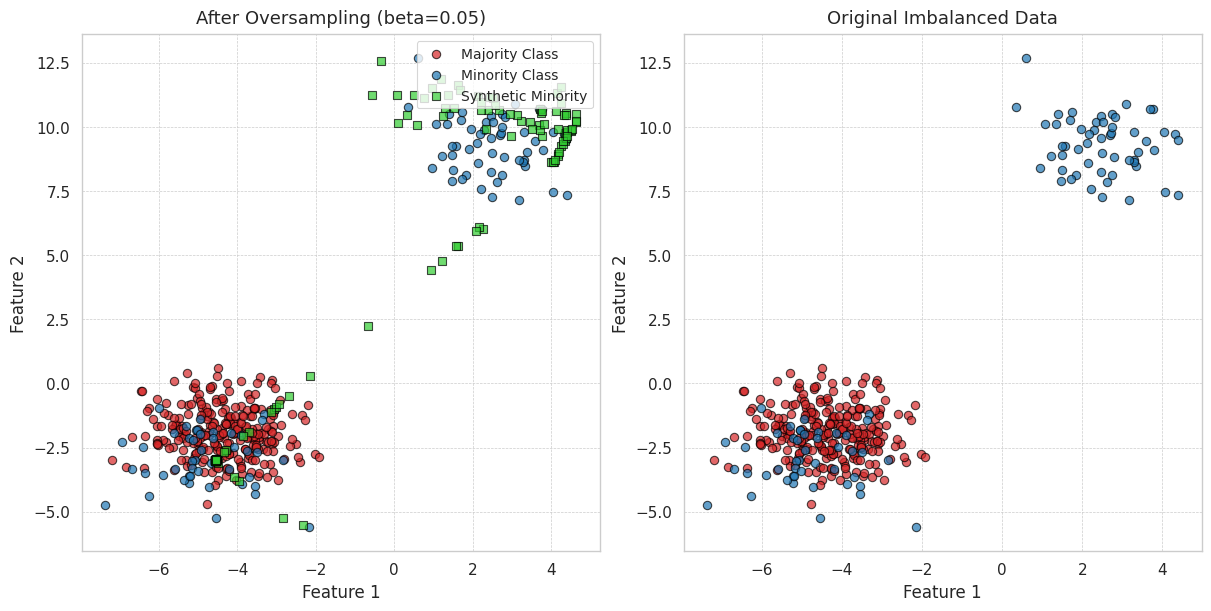

Metrics for Sim4 (beta: 0.05): AUROC=0.8325, G-mean=0.7501, mAP=0.9074, F1=0.7471

===== Sim4 | beta=0.1 =====
Epoch [500/1000] MMD = 0.0087 Trip = 1.0767 (beta=0.1)
Epoch [1000/1000] MMD = 0.0078 Trip = 1.0319 (beta=0.1)


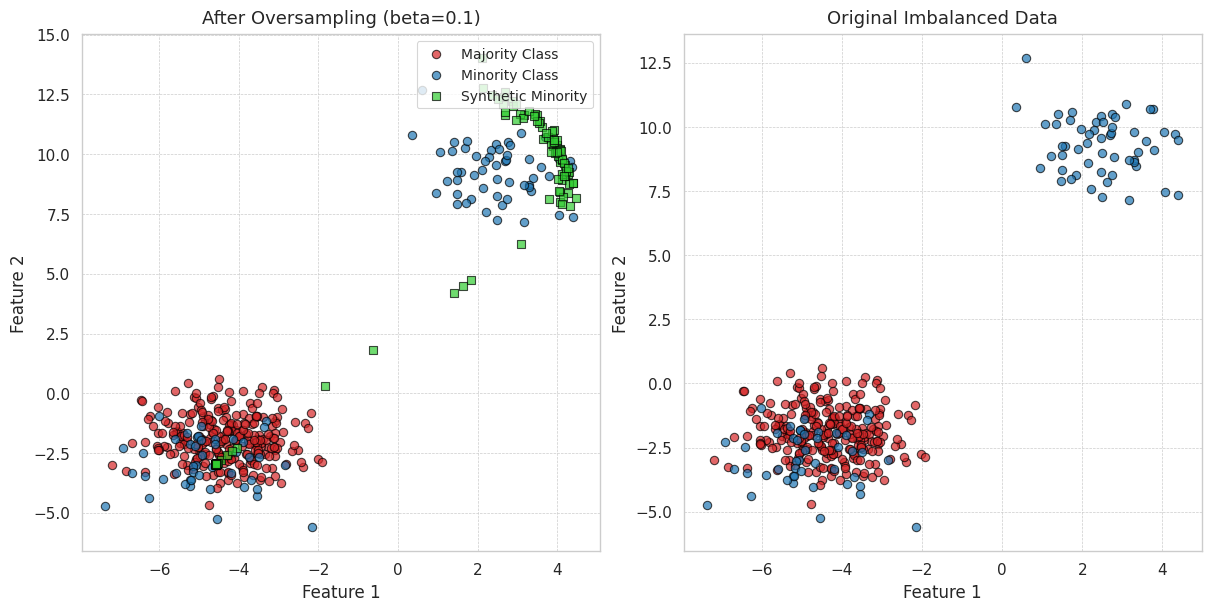

Metrics for Sim4 (beta: 0.1): AUROC=0.8325, G-mean=0.7649, mAP=0.9068, F1=0.7735
Metrics for Sim5 (Original Imbalanced): AUROC=0.9069, G-mean=0.8017, mAP=0.8099, F1=0.7429

===== Sim5 | beta=0.0 =====
Epoch [500/1000] MMD = 0.0031 Trip = 0.0000 (beta=0.0)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.0)


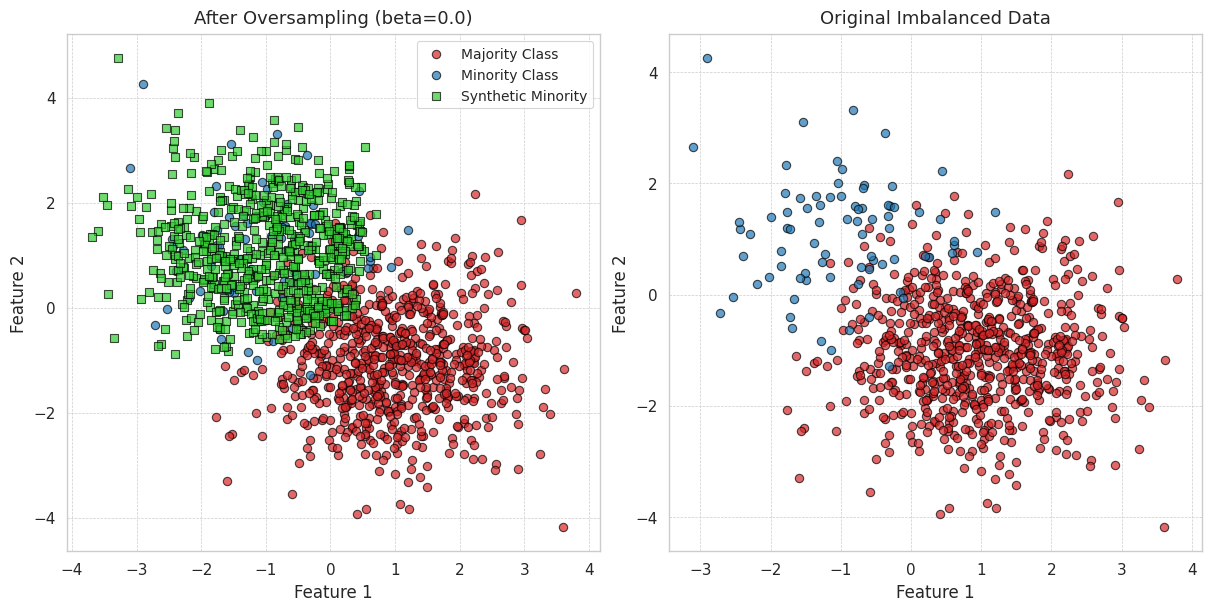

Metrics for Sim5 (beta: 0.0): AUROC=0.9542, G-mean=0.8773, mAP=0.7055, F1=0.6296

===== Sim5 | beta=0.005 =====
Epoch [500/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.005)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.005)


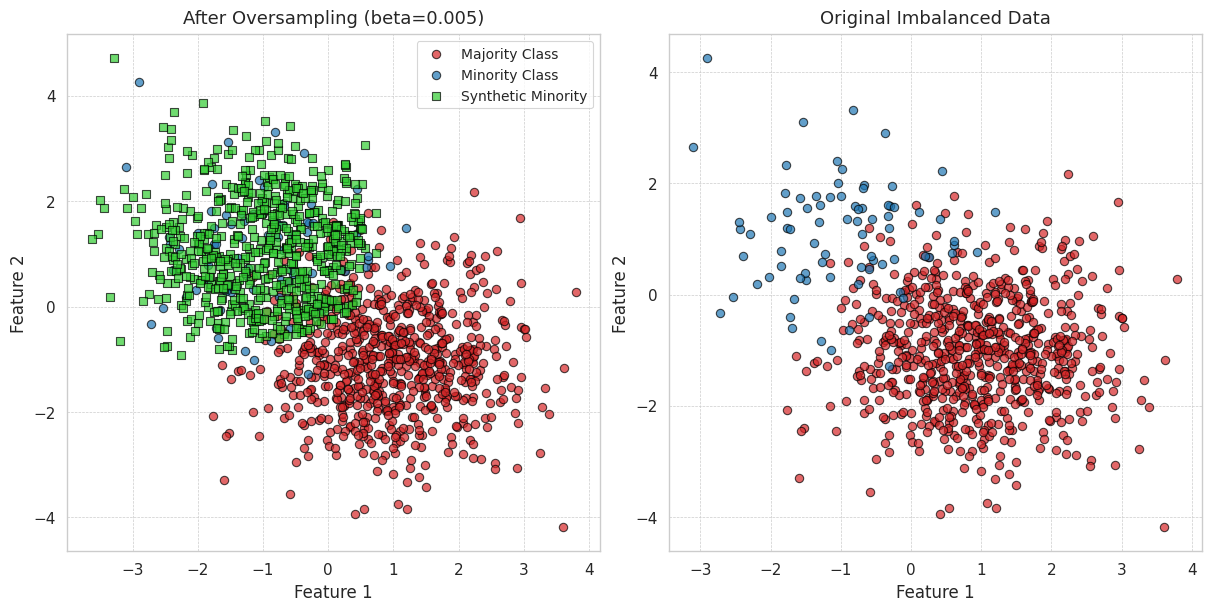

Metrics for Sim5 (beta: 0.005): AUROC=0.9556, G-mean=0.9028, mAP=0.7241, F1=0.6545

===== Sim5 | beta=0.01 =====
Epoch [500/1000] MMD = 0.0000 Trip = 0.0002 (beta=0.01)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.01)


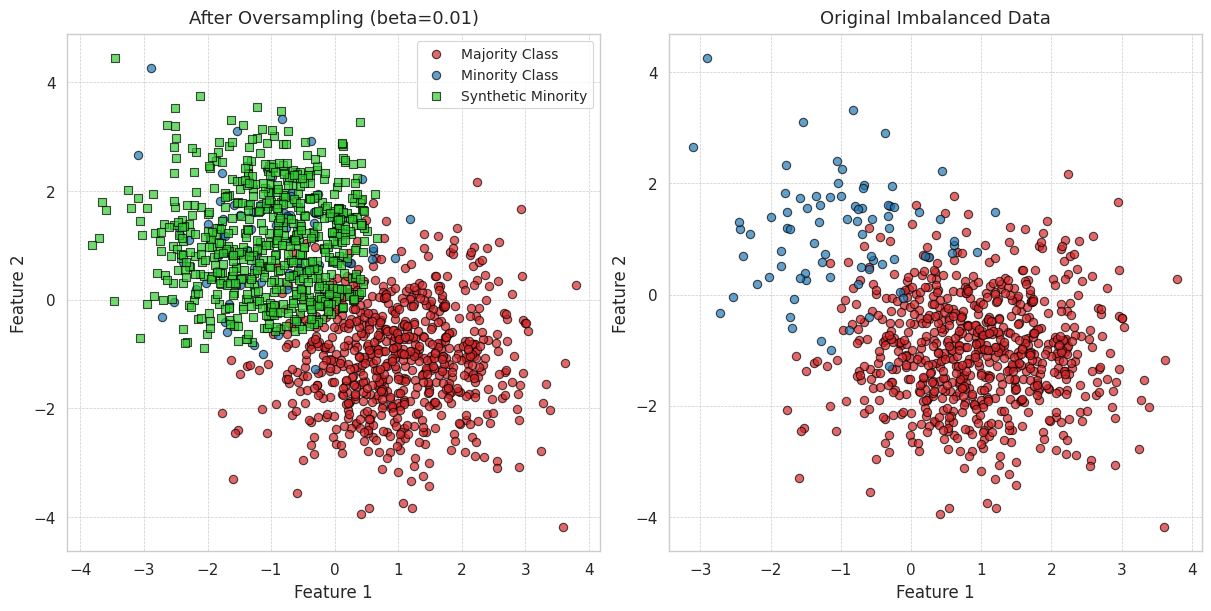

Metrics for Sim5 (beta: 0.01): AUROC=0.9544, G-mean=0.9028, mAP=0.6856, F1=0.6545

===== Sim5 | beta=0.05 =====
Epoch [500/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.05)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.05)


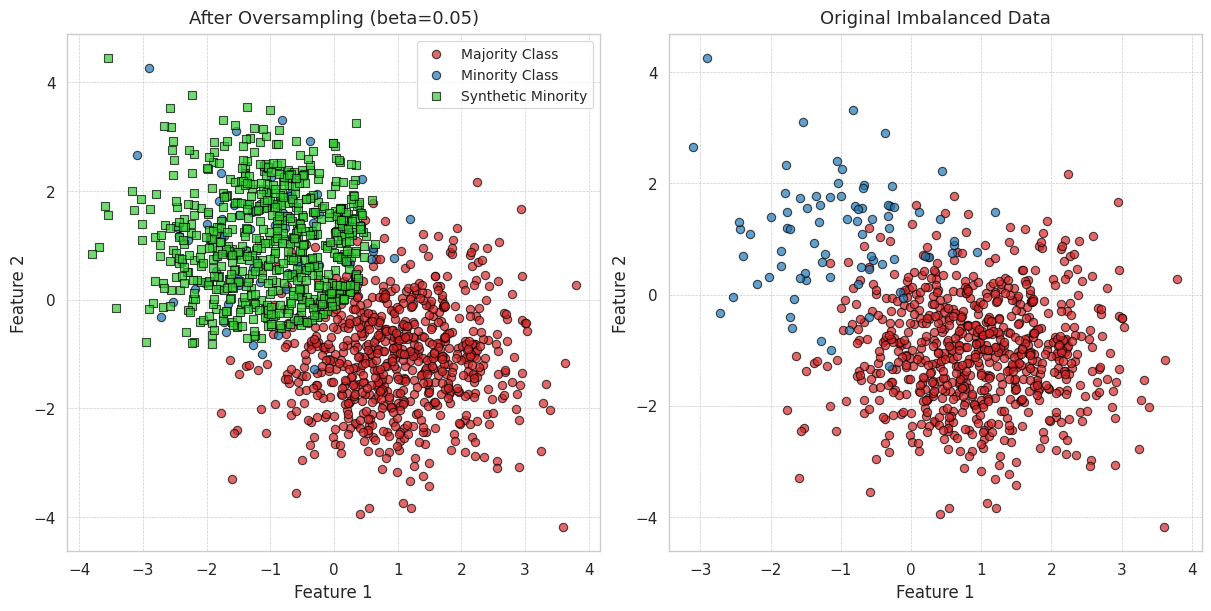

Metrics for Sim5 (beta: 0.05): AUROC=0.9536, G-mean=0.9000, mAP=0.6572, F1=0.6429

===== Sim5 | beta=0.1 =====
Epoch [500/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.1)
Epoch [1000/1000] MMD = 0.0000 Trip = 0.0000 (beta=0.1)


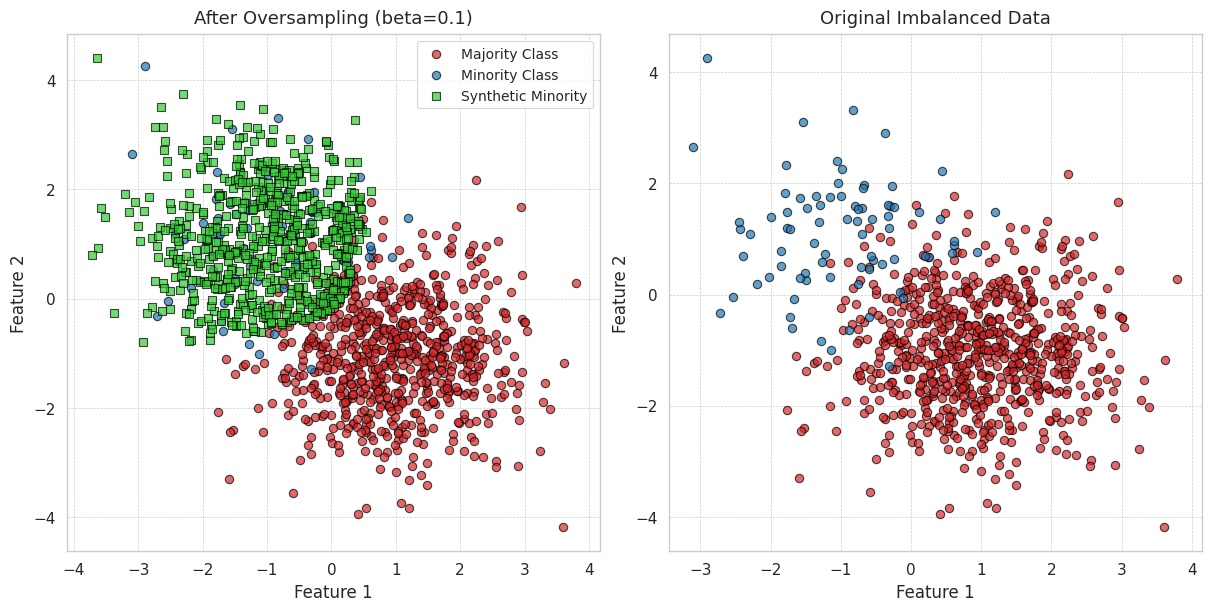

Metrics for Sim5 (beta: 0.1): AUROC=0.9533, G-mean=0.9000, mAP=0.6600, F1=0.6429

Results for Sim1:
  Original Imbalanced:
    AUROC: 0.8077
    Gmean: 0.3412
    mAP: 0.7797
    F1: 0.2087
  Oversampled:
    beta=0.0: AUROC=0.8975, G-mean=0.8062, mAP=0.8347, F1=0.8435
    beta=0.005: AUROC=0.8967, G-mean=0.8139, mAP=0.8532, F1=0.8458
    beta=0.01: AUROC=0.8931, G-mean=0.8096, mAP=0.8413, F1=0.8407
    beta=0.05: AUROC=0.8627, G-mean=0.7576, mAP=0.8064, F1=0.7736
    beta=0.1: AUROC=0.8727, G-mean=0.7831, mAP=0.8374, F1=0.7962

Results for Sim2:
  Original Imbalanced:
    AUROC: 0.9816
    Gmean: 0.9033
    mAP: 0.9824
    F1: 0.8995
  Oversampled:
    beta=0.0: AUROC=0.9808, G-mean=0.9398, mAP=0.9815, F1=0.9412
    beta=0.005: AUROC=0.9786, G-mean=0.9247, mAP=0.9795, F1=0.9268
    beta=0.01: AUROC=0.9783, G-mean=0.9247, mAP=0.9794, F1=0.9268
    beta=0.05: AUROC=0.9744, G-mean=0.9149, mAP=0.9749, F1=0.9137
    beta=0.1: AUROC=0.9778, G-mean=0.9295, mAP=0.9781, F1=0.9278

Results for 

In [20]:
def main():
    run_clf_exp(seed=seed)

if __name__ == "__main__":
    main()